## ANALYSIS OF THE CORRELATIONS

In [1]:
import pandas as pd
import numpy as np
import datetime as DT
import requests
import json 
import warnings
import seaborn as sns
from sklearn.cluster import KMeans  #per fare clusters

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
from scipy import stats as sps
warnings.filterwarnings('ignore')
from adjustText import adjust_text

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df=pd.read_csv('FULL_DATA5_FINALE.csv')
indicators = [
    "mask",
    "worried_catch_covid",
    "belief_masking_effective",
    "received_news_local_health",
    "received_news_experts",
    "received_news_who",
    "received_news_govt_health",
    "received_news_politicians",
    "received_news_journalists",
    "received_news_friends",
    "trust_covid_info_local_health",
    "trust_covid_info_experts",
    "trust_covid_info_who",
    "trust_covid_info_govt_health",
    "trust_covid_info_politicians",
    "trust_covid_info_journalists",
    "trust_covid_info_friends"
]

In [ ]:
import scipy.stats #shannon entropy
def shannon_entropy_scipy(data):   
    return scipy.stats.entropy(data, base=2)

def shannon(countri, ind): #mi resittuisce il valore della shennon entropy H
    dfj = df[df['country'] == countri].copy()
    counts, bin_edges = np.histogram(dfj[ind].dropna(), bins='fd')  #fd perchè così li sceglie lui il numero di suddivisioni(bin). Freedman-Diaconis
    probabilities = counts / (counts.sum())
   
    nonzero_probs = probabilities[probabilities > 0]
    H = shannon_entropy_scipy(nonzero_probs)
    H_normalized = H / np.log2(len(nonzero_probs)) if len(nonzero_probs) > 1 else 0  #fatto per normalizzarlo
    
    return H


In [ ]:
def calculate_correlations(var1, var2):
    """calcola le correlazioni tra due variabili per ogni paese"""
    corr_list = []
    for country, group in df.groupby('country'):
        group_clean = group[[var1, var2]].dropna()
        if len(group_clean) >= 2:
            corr = group_clean.corr().iloc[0, 1]
            corr_list.append({'country': country, 'correlation': corr})
    
    return pd.DataFrame(corr_list)

In [5]:
def add_outliers(ax, data, x_pos):
    label_offset = 0.02
    min_spacing = 0.05  # distanza minima tra le etichette in y
    
    Q1 = data['correlation'].quantile(0.25)
    Q3 = data['correlation'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data['correlation'] < (Q1 - 1.5*IQR)) |  (data['correlation'] > (Q3 + 1.5*IQR))]
    
    # ordina gli outlier secondo la corr
    outliers = outliers.sort_values('correlation')
    previous_y = None
    
    for _, row in outliers.iterrows():
        current_y = row['correlation']
        
        # Regola la posizione y se troppo vicina alla precedente
        if previous_y is not None and abs(current_y - previous_y) < min_spacing:
            current_y = previous_y + min_spacing * (1 if current_y > previous_y else -1)
        
        ax.plot(x_pos, row['correlation'], 'o', 
                color='black',
                markersize=8,
                markeredgewidth=1,
                markeredgecolor='black')

        ax.text(x_pos + label_offset,
                current_y,
                f" {row['country']} ({row['correlation']:.2f})",
                ha='left', 
                va='center',
                fontsize=12)
        
        previous_y = current_y

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 12
test   = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables) #crea una matrice quadrata vuota (zeri) di dimensioni n x n, con n= numero di variabili.
    for c in df.columns: #per ogni variabile -> x
        for r in df.index: #per ogni variabile --> y
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False) #fa test
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]   #fa pvalue per ogni lag
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values) #valore minimo tra i pvalue sui 12 lag.
            df.loc[r, c] = min_p_value #viene salvato nella matrice finale solo il valore min
    df.columns = [var + '_x' for var in variables] #rinomna righe e colonne
    df.index = [var + '_y' for var in variables]
    return df

In [ ]:
def boxplot2(correlations_df1, correlations_df2, name1, name2, title, nomesalvataggio):
    """Immagine con 2 boxplot"""
    # Pìpreparazione dati
    df1 = correlations_df1.copy()
    df2 = correlations_df2.copy()
    df1['dataset'] = name1
    df2['dataset'] = name2
    combined_df = pd.concat([df1, df2])

    #figura
    plt.figure(figsize=(8, 6))
    ax = sns.boxplot(
        x='dataset',
        y='correlation',
        data=combined_df,
        width=0.4,
        showfliers=False,
        boxprops=dict(facecolor='white', edgecolor='black', linewidth=1), #per fare grandezza dei plot
        whiskerprops=dict(color='black', linewidth=1),
        capprops=dict(color='black', linewidth=1),
        medianprops=dict(color='red', linewidth=2)
    )

    # Aggiunta outlier
    add_outliers(ax, df1, 0)
    add_outliers(ax, df2, 1)
    current_xlim = ax.get_xlim()
    ax.set_xlim(current_xlim[0], current_xlim[1] + 0.5) #per aggiungere spazio a dx per le etichette
    ax.set_xticklabels([name1, name2], fontsize=14)
    
    plt.axhline(0, color='gray', linestyle=':', alpha=0.5)
    plt.title(title, fontsize=14, pad=15)
    plt.ylabel('Correlations', fontsize=14)
    plt.xlabel('',fontsize=14)
    plt.grid(axis='y', linestyle=':', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'C:\\Users\\user\\Desktop\\immaginitt\\immparte2correlazione\\{nomesalvataggio}.png')
    plt.show()


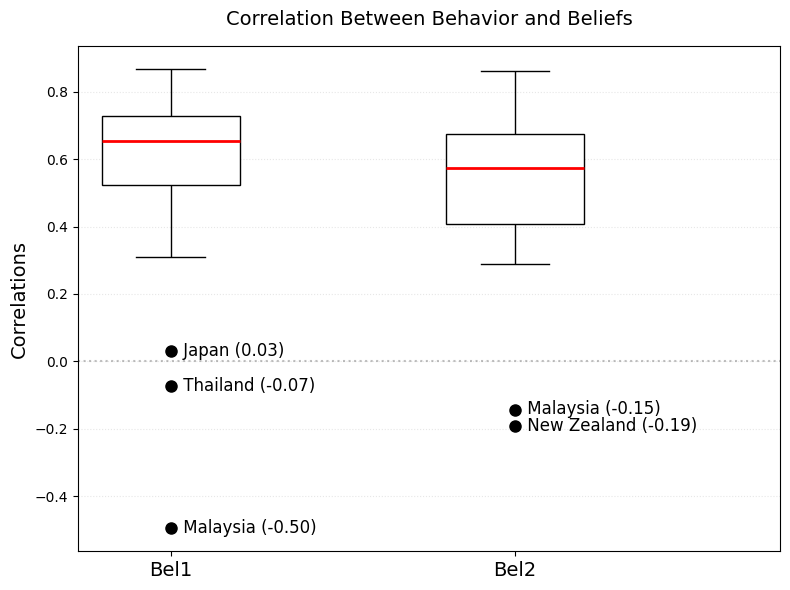

In [8]:
corr1=calculate_correlations("pct_mask","pct_worried_catch_covid")
corr2=calculate_correlations("pct_mask", "pct_belief_masking_effective")
boxplot2(corr1,corr2, 'Bel1', 'Bel2', 'Correlation Between Behavior and Beliefs', 'BB')

In [9]:
def shannon(countri, ind):
    dfj = df[df['country'] == countri].copy()
    counts, bin_edges = np.histogram(dfj[ind].dropna(), bins='fd')
    probabilities = counts / counts.sum()
    
    H = scipy.stats.entropy(probabilities, base=2)
    max_entropy = np.log2(len(probabilities))  # log2 del numero totale di bin
    
    H_normalized = H / max_entropy if max_entropy > 0 else 0
    return H_normalized

In [10]:
print(shannon('Japan', 'pct_mask')) #beh
print(shannon('Thailand', 'pct_mask'))
print(shannon('Malaysia', 'pct_mask'))
print(shannon('New Zealand', 'pct_mask'))

print(shannon('Japan', 'pct_worried_catch_covid')) #bel1
print(shannon('Thailand', 'pct_worried_catch_covid'))
print(shannon('Malaysia', 'pct_worried_catch_covid'))

print(shannon('New Zealand', 'pct_belief_masking_effective')) #bel2
print(shannon('Malaysia', 'pct_belief_masking_effective'))

0.8397233467178075
0.8724112484477976
0.9018536441248436
0.6855409495084308
0.9126714352608307
0.8950398577204961
0.8665594328606958
0.8364817106993988
0.810192141225889


In [11]:
grangers_causation_matrix(df[['pct_mask', 'pct_worried_catch_covid']].dropna(), variables =['pct_mask', 'pct_worried_catch_covid']) 
#in quetso caso ho che <0.05 ottengo che x do not granger cause y.  invece altro ho che new deaths è granger cause di y

pct_mask_x  pct_worried_catch_covid_x
pct_mask_y                        1.0                        0.0
pct_worried_catch_covid_y         0.0                        1.0

In [12]:
grangers_causation_matrix(df[['pct_mask', 'pct_belief_masking_effective']].dropna(), variables =['pct_mask', 'pct_belief_masking_effective']) 

pct_mask_x  pct_belief_masking_effective_x
pct_mask_y                             1.0                             0.0
pct_belief_masking_effective_y         0.0                             1.0

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

b = df[['pct_mask', 'pct_worried_catch_covid', 'pct_belief_masking_effective']].copy().dropna()

X = b[['pct_worried_catch_covid', 'pct_belief_masking_effective']]
y = b['pct_mask']

X = sm.add_constant(X)  # aggiunge la colonna 'const'

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               pct_mask   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                 1.328e+04
Date:                Sat, 02 Aug 2025   Prob (F-statistic):               0.00
Time:                        11:14:13   Log-Likelihood:                 5607.5
No. Observations:               13165   AIC:                        -1.121e+04
Df Residuals:                   13162   BIC:                        -1.119e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [14]:
def boxplot7(correlations_dfs, names, title, nomesalvataggio):
    """ 7 boxplot nell'immagine"""

    combined_df = pd.DataFrame()
    for i in range(len(correlations_dfs)): #combino i dataset
        dfi = correlations_dfs[i].copy()
        dfi['dataset'] = names[i]
        combined_df = pd.concat([combined_df, dfi])

    #figure
    plt.figure(figsize=(14, 8))
    ax = sns.boxplot(
        x='dataset',
        y='correlation',
        data=combined_df,
        width=0.6,
        showfliers=False,
        boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
        whiskerprops=dict(color='black', linewidth=1),
        capprops=dict(color='black', linewidth=1),
        medianprops=dict(color='red', linewidth=2)
    )

    for i in range(len(correlations_dfs)):     # aggiungo gli outlier per ogni dataset
        dfi = correlations_dfs[i].copy()
        dfi['dataset'] = names[i]
        add_outliers(ax, dfi, i)

    current_xlim = ax.get_xlim()
    ax.set_xlim(current_xlim[0], current_xlim[1] + 0.5) #per aggiungere spazio a dx per le etichette

    plt.axhline(0, color='gray', linestyle=':', alpha=0.5)
    plt.title(title, fontsize=15, pad=15)
    plt.ylabel('Correlations', fontsize=15)
    plt.xlabel('')
    plt.xticks(fontsize=14)
    plt.grid(axis='y', linestyle=':', alpha=0.3)
    plt.savefig(f'C:\\Users\\user\\Desktop\\immaginitt\\immparte2correlazione\\{nomesalvataggio}.png')
    plt.show()

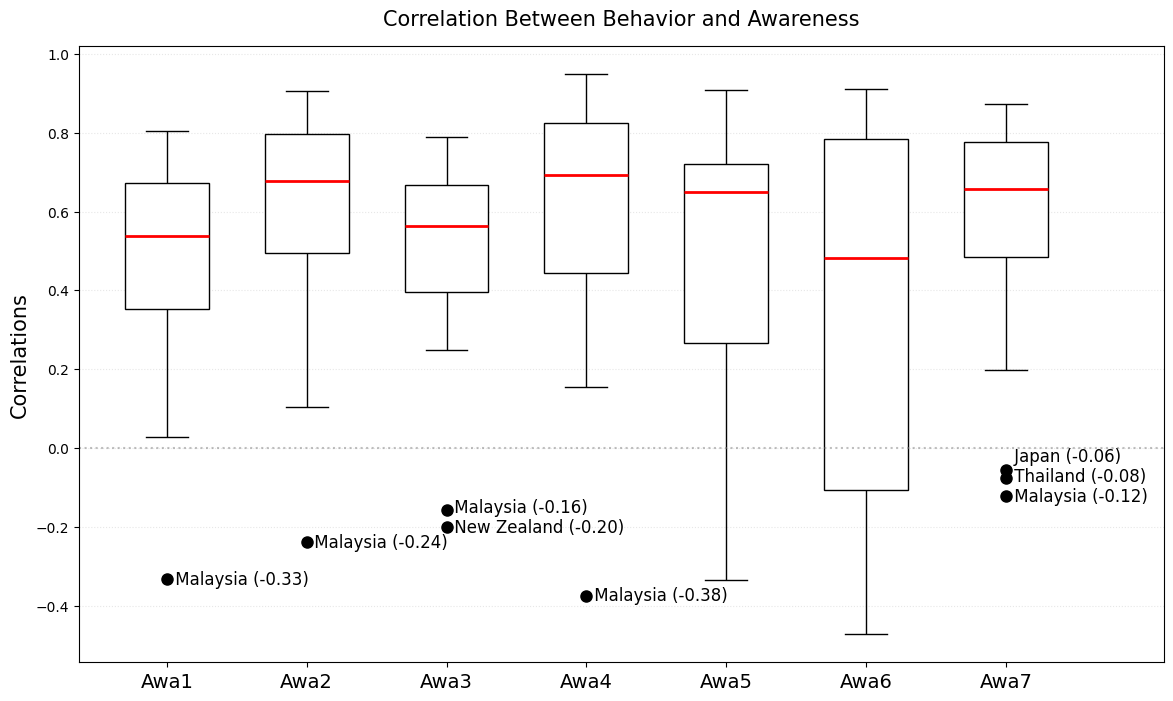

In [15]:
corr1=calculate_correlations("pct_mask","pct_received_news_local_health")
corr2=calculate_correlations("pct_mask","pct_received_news_experts")
corr3=calculate_correlations("pct_mask","pct_received_news_who")
corr4=calculate_correlations("pct_mask","pct_received_news_govt_health")
corr5=calculate_correlations("pct_mask","pct_received_news_politicians")
corr6=calculate_correlations("pct_mask","pct_received_news_journalists")
corr7=calculate_correlations("pct_mask","pct_received_news_friends")
corr=[corr1, corr2, corr3, corr4, corr5, corr6, corr7]
names=['Awa1', 'Awa2','Awa3','Awa4','Awa5','Awa6','Awa7']
boxplot7(corr, names, 'Correlation Between Behavior and Awareness', 'BA')

clusterss-> kemnas-> minimizzare la distanza tra ogni punto dati e il centroide del proprio cluster. 

In [16]:
Europe= ['Austria', 'Belgium', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany',
               'Greece', 'Hungary', 'Italy', 'Netherlands', 'Norway', 'Poland', 'Portugal',
               'Romania', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom']  
Latin_America=['Argentina', 'Chile', 'Colombia', 'Ecuador', 'Peru', 'Mexico']   
Asia=['Indonesia', 'Japan', 'Malaysia', 'Philippines', 'Thailand'] 
Oceania=['Australia', 'New Zealand']
North_America= ['Canada']

def continent(country):
    if country in Europe:
        return 'Europe'
    elif country in Latin_America:
        return 'Latin_America'
    elif country in Asia:
        return 'Asia'
    elif country in Oceania:
        return 'Oceania'
    elif country in North_America:
        return 'North_America'
    else:
        return 'Other'
    
palettes = {
    'Europe':        '#0173B2',  # blu
    'Asia':          '#CC78BC',  # viola
    'Latin_America': '#DE8F05',  # arancione
    'North_America': '#D55E00',  # rosso-mattone
    'Oceania':       '#029E73'   # verde
}



In [17]:
def plot_aree(corr, title, nomesalvataggio): #fa il plot per aree geografiche 
    countries = df['country'].unique()
    dl= corr
    dl['Area'] = dl['country'].apply(continent)
    dl_sorted = dl.sort_values(by='correlation', ascending=False)
    kmeans = KMeans(n_clusters=3, random_state=0)
    kmeans.fit(dl[['correlation']])  # fit sul dato 2D
    centroids = kmeans.cluster_centers_.flatten() #estraggo i centroidi che sono array dentro un arrey tipo [[0.2], [0.7],...]
    centroids.sort()

    # linee di divisione dei clusters: metà tra i due centroidi vicini
    division_lines=[]
    for i in range(len(centroids)-1):
        division_lines.append((centroids[i] + centroids[i+1])/2)

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.scatterplot(x='correlation', y='country', data=dl_sorted, s=100, hue='Area',palette=palettes, ax=ax)
    for line in division_lines:
        ax.axvline(x=line, color='red', linestyle='--') #dividere i cluster con le linee rosse verticali, cluster li vedo nell'immagine prima
    ax.set_title(title)
    ax.grid(True)
    #ax.legend(title='Geographic Area', bbox_to_anchor=(1.05, 1), loc='upper left')

    leg1 = ax.legend(title='Geographic Area', bbox_to_anchor=(1.05, 1), loc='upper left')
    red_line = Line2D([0], [0], color='red', linestyle='--', label='Cluster division K-Means')
    leg2 = ax.legend(handles=[red_line], bbox_to_anchor=(1.05, 0.70), loc='upper left', frameon=True)
    ax.add_artist(leg1)
    plt.savefig(f'C:\\Users\\user\\Desktop\\immaginitt\\immparte2correlazione\\{nomesalvataggio}.png')
    plt.tight_layout()



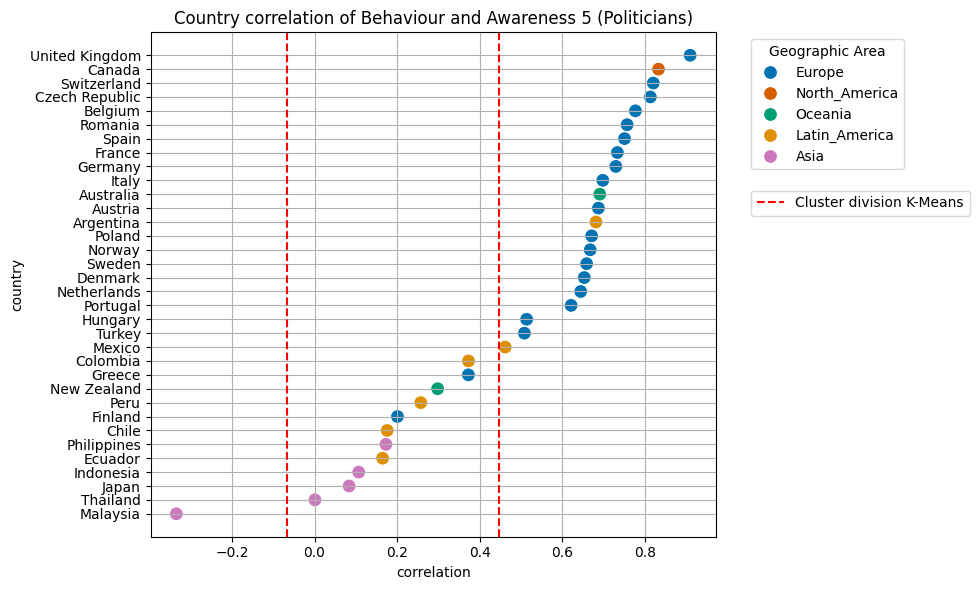

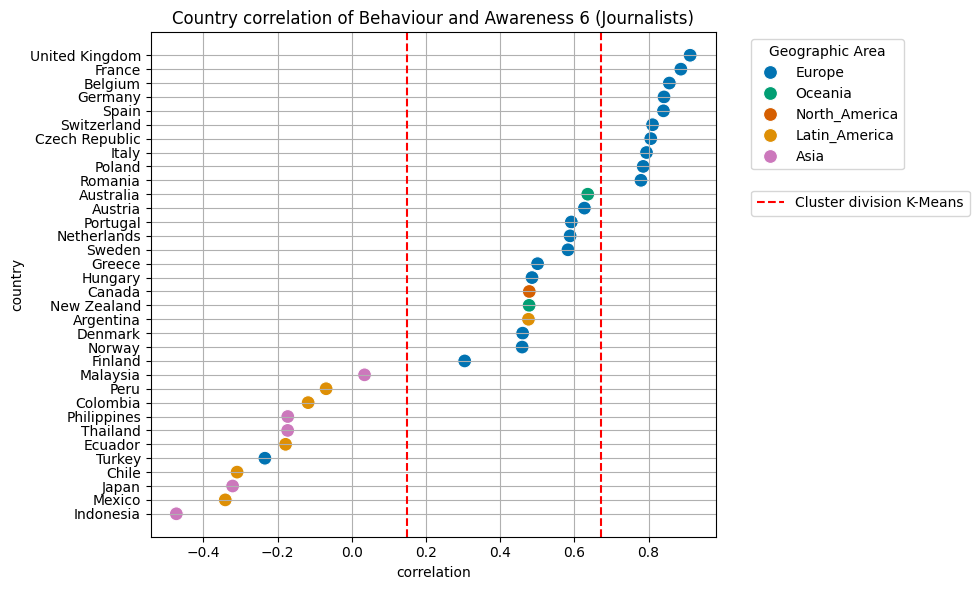

In [18]:
plot_aree(corr5, 'Country correlation of Behaviour and Awareness 5 (Politicians)', 'BAanalisi5')
plot_aree(corr6, 'Country correlation of Behaviour and Awareness 6 (Journalists)', 'BAanalisi6')

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

b = df[['pct_mask', 'pct_received_news_local_health', 'pct_received_news_experts', 'pct_received_news_who', 'pct_received_news_govt_health', 'pct_received_news_politicians', 'pct_received_news_journalists', 'pct_received_news_friends' ]].copy().dropna()

X = b[['pct_received_news_local_health', 'pct_received_news_experts', 'pct_received_news_who', 'pct_received_news_govt_health', 'pct_received_news_politicians', 'pct_received_news_journalists', 'pct_received_news_friends' ]]
y = b['pct_mask']

X = sm.add_constant(X)  # aggiunge la colonna 'const'

model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               pct_mask   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     2183.
Date:                Sat, 02 Aug 2025   Prob (F-statistic):               0.00
Time:                        11:14:18   Log-Likelihood:                 3433.7
No. Observations:               13134   AIC:                            -6851.
Df Residuals:                   13126   BIC:                            -6792.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [20]:
# aggiungo colonna di 1 per intercetta
X['intercept'] = 1
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                          feature       VIF
0                           const  0.000000
1  pct_received_news_local_health  4.022010
2       pct_received_news_experts  1.841751
3           pct_received_news_who  2.348200
4   pct_received_news_govt_health  3.216998
5   pct_received_news_politicians  3.354210
6   pct_received_news_journalists  1.277228
7       pct_received_news_friends  2.615524
8                       intercept  0.000000


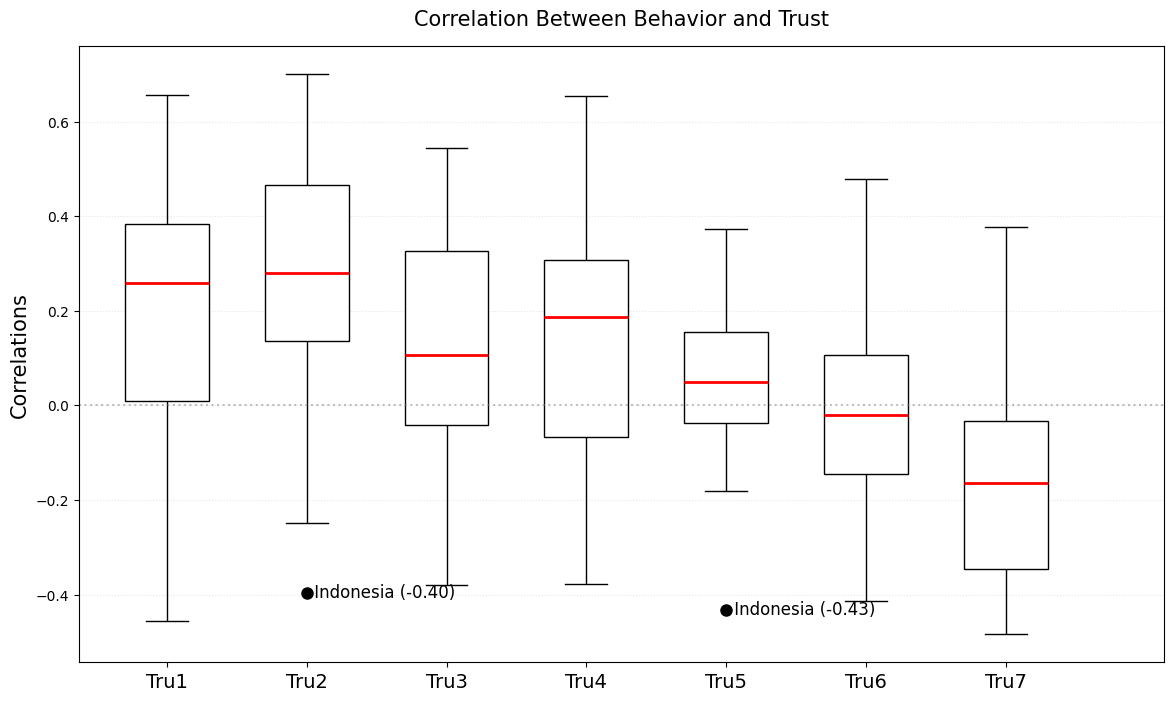

In [21]:
cort1=calculate_correlations("pct_mask","pct_trust_covid_info_local_health")
cort2=calculate_correlations("pct_mask","pct_trust_covid_info_experts")
cort3=calculate_correlations("pct_mask","pct_trust_covid_info_who")
cort4=calculate_correlations("pct_mask","pct_trust_covid_info_govt_health")
cort5=calculate_correlations("pct_mask","pct_trust_covid_info_politicians")
cort6=calculate_correlations("pct_mask","pct_trust_covid_info_journalists")
cort7=calculate_correlations("pct_mask","pct_trust_covid_info_friends")
cort=[cort1, cort2, cort3, cort4, cort5, cort6, cort7]
names=['Tru1', 'Tru2','Tru3','Tru4','Tru5','Tru6','Tru7']
boxplot7(cort, names, 'Correlation Between Behavior and Trust', 'BT')

awareness/trust VS behaviour

In [22]:
chi = ['local_health','experts','who',  'govt_health', 'politicians', 'journalists', 'friends' ]

for src in chi:
    awareness_col = f'pct_received_news_{src}'
    trust_col = f'pct_trust_covid_info_{src}'
    new_col = f'at_{src}'
    
    # crea la nuova colonna awareness / trust
    df[new_col] = df[awareness_col] / df[trust_col]


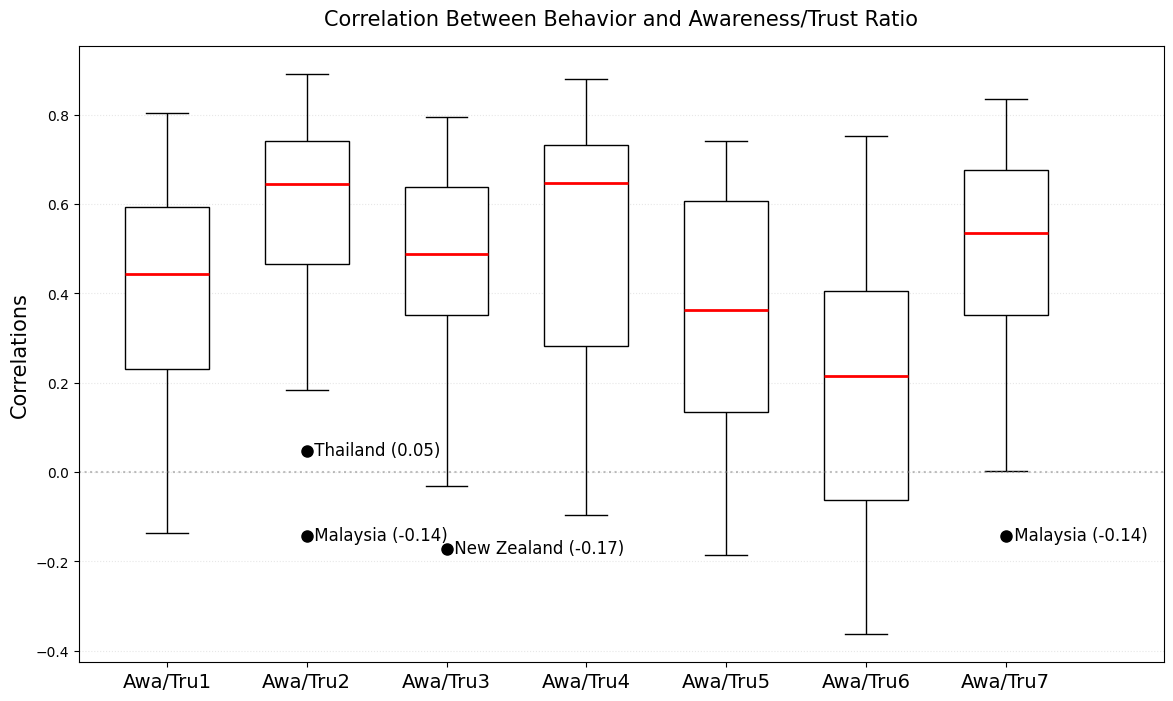

In [23]:
cor1=calculate_correlations("pct_mask","at_local_health")
cor2=calculate_correlations("pct_mask","at_experts")
cor3=calculate_correlations("pct_mask","at_who")
cor4=calculate_correlations("pct_mask","at_govt_health")
cor5=calculate_correlations("pct_mask","at_politicians")
cor6=calculate_correlations("pct_mask","at_journalists")
cor7=calculate_correlations("pct_mask","at_friends")

cor=[cor1, cor2, cor3, cor4, cor5, cor6, cor7]
names=['Awa/Tru1', 'Awa/Tru2', 'Awa/Tru3', 'Awa/Tru4', 'Awa/Tru5', 'Awa/Tru6', 'Awa/Tru7']
boxplot7(cor, names, 'Correlation Between Behavior and Awareness/Trust Ratio', 'BAT')


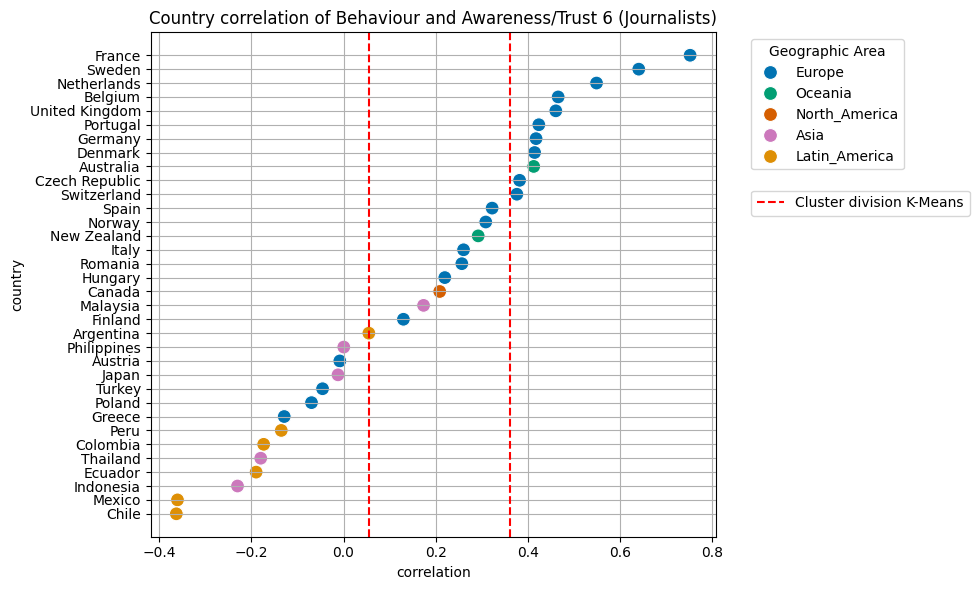

In [24]:
plot_aree(cor6, 'Country correlation of Behaviour and Awareness/Trust 6 (Journalists)', 'BATanalisi6')

In [25]:
grangers_causation_matrix(df[['pct_mask', 'at_local_health']].dropna(), variables =['pct_mask', 'at_local_health']) 

pct_mask_x  at_local_health_x
pct_mask_y                1.0             0.0001
at_local_health_y         0.0             1.0000

In [26]:
grangers_causation_matrix(df[['pct_mask', 'at_experts']].dropna(), variables =['pct_mask', 'at_experts']) 

pct_mask_x  at_experts_x
pct_mask_y           1.0        0.0331
at_experts_y         0.0        1.0000

In [27]:
grangers_causation_matrix(df[['pct_mask', 'at_who']].dropna(), variables =['pct_mask', 'at_who']) 

pct_mask_x  at_who_x
pct_mask_y         1.0    0.0335
at_who_y           0.0    1.0000

In [28]:
grangers_causation_matrix(df[['pct_mask', 'at_govt_health']].dropna(), variables =['pct_mask', 'at_govt_health']) 

pct_mask_x  at_govt_health_x
pct_mask_y               1.0            0.0129
at_govt_health_y         0.0            1.0000

In [29]:
df_clean = df[['pct_mask', 'at_politicians']].copy()
df_clean = df_clean.dropna()
df_clean = df_clean[~df_clean.isin([np.inf, -np.inf]).any(axis=1)]
grangers_causation_matrix(df_clean , variables =['pct_mask', 'at_politicians']) 

pct_mask_x  at_politicians_x
pct_mask_y            1.0000            0.2405
at_politicians_y      0.0007            1.0000

In [30]:
grangers_causation_matrix(df[['pct_mask', 'at_journalists']].dropna(), variables =['pct_mask', 'at_journalists']) 

pct_mask_x  at_journalists_x
pct_mask_y               1.0               0.0
at_journalists_y         0.0               1.0

In [31]:
grangers_causation_matrix(df[['pct_mask', 'at_friends']].dropna(), variables =['pct_mask', 'at_friends']) 

pct_mask_x  at_friends_x
pct_mask_y           1.0        0.0263
at_friends_y         0.0        1.0000

## new deaths VS beh

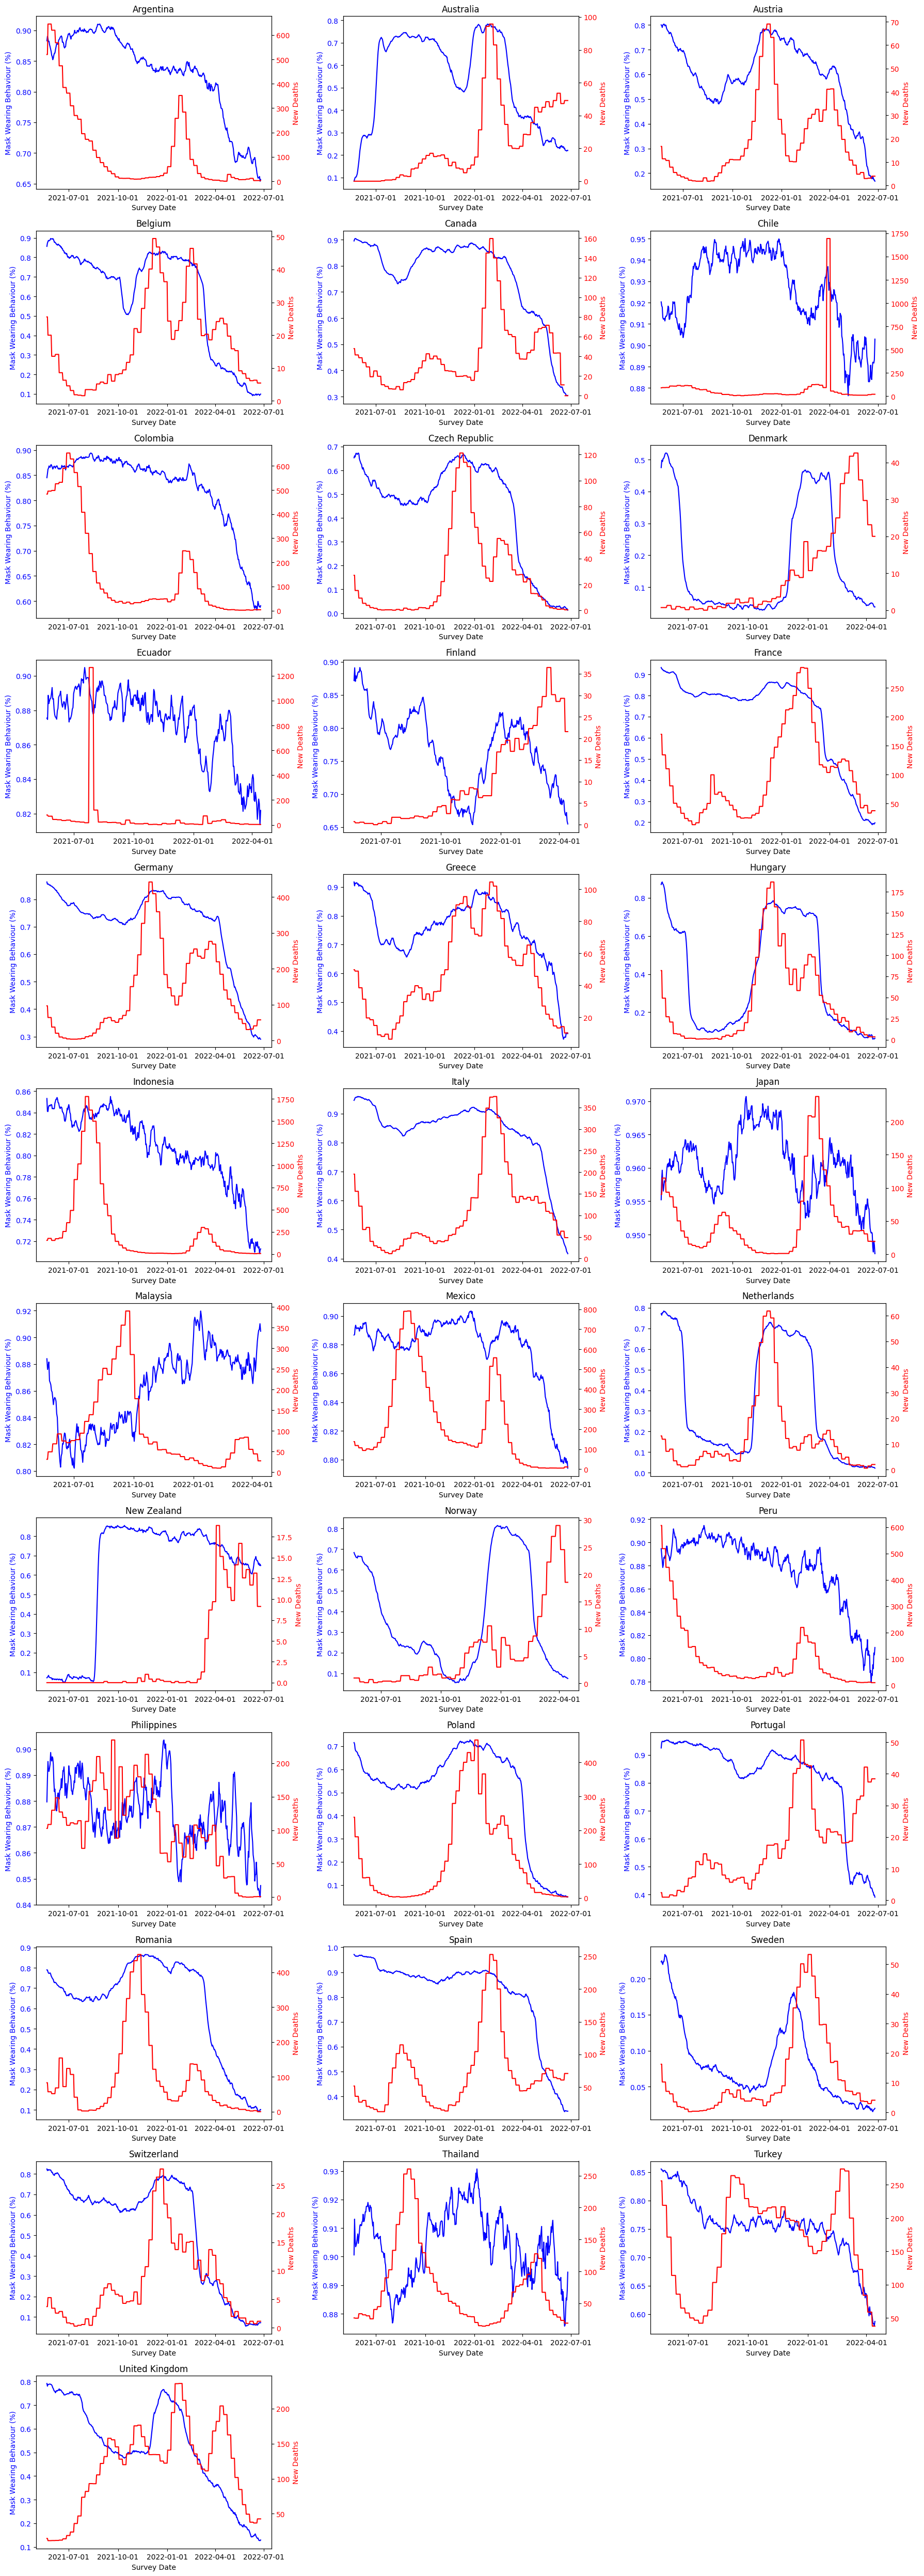

In [ ]:
behdeath = df[['country', 'pct_mask', 'survey_date', 'total_deaths', 'new_deaths_smoothed']].copy()
behdeath['survey_date'] = pd.to_datetime(behdeath['survey_date'])

lista_paesi = behdeath['country'].unique()  
fig, axs = plt.subplots(12, 3, figsize=(18, 50), sharex=False)
axs = axs.flatten() 

for i, paese in enumerate(lista_paesi):
    df_paese = behdeath[behdeath['country'] == paese].copy()
    df_paese.set_index('survey_date', inplace=True)     # imposta l'indice come datetime altriemnti non va
    # Calcolo media mobile 7 giorni solo su pct_mask
    pct_mask_smooth = df_paese['pct_mask'].rolling('7D', min_periods=1).mean()
    df_smooth = df_paese.copy()
    df_smooth['pct_mask'] = pct_mask_smooth
    # cambia indice per il plot
    df_smooth.reset_index(inplace=True)

    ax1 = axs[i]
    ax1.plot(df_smooth['survey_date'], df_smooth['pct_mask'], color='blue', label='Mask Wearing Behaviour (%)')
    ax1.set_ylabel('Mask Wearing Behaviour (%)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(df_smooth['survey_date'], df_smooth['new_deaths_smoothed'], color='red', label='New Deaths')
    ax2.set_ylabel('New Deaths', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    ax1.set_title(paese)
    ax1.set_xlabel('Survey Date')

    #date asse x non tutte ma solo alcune 
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=6))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rimuove subplot vuoti
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


In [33]:
grangers_causation_matrix(df[['pct_mask', 'new_deaths_smoothed']].dropna(), variables =['pct_mask', 'new_deaths_smoothed']) 
#in quetso caso ho che <0.05 ottengo che x do not granger cause y.  invece altro ho che new deaths è granger cause di y

pct_mask_x  new_deaths_smoothed_x
pct_mask_y                 1.0000                 0.2059
new_deaths_smoothed_y      0.0304                 1.0000

ci sono due picchi incontrollati in ecuador e chile e li smussamo, probabilemnte vengono da errrori di scrittura dei dati:

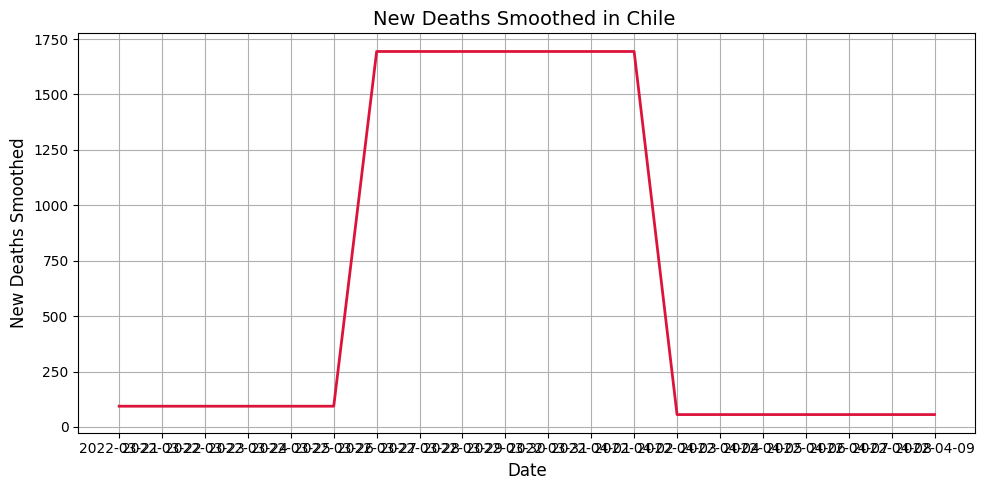

In [34]:
dfft=df[df['country']== 'Chile'][['survey_date', 'new_deaths_smoothed']]
dfft=dfft[(dfft['survey_date']> '2022-03-20') & (dfft['survey_date']< '2022-04-1')]
plt.figure(figsize=(10, 5))
plt.plot(dfft['survey_date'], dfft['new_deaths_smoothed'], color='crimson', linewidth=2)

plt.title('New Deaths Smoothed in Chile ', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('New Deaths Smoothed', fontsize=12)
plt.grid(True)
plt.tight_layout()

# Mostra il grafico
plt.show()

In [35]:
dfft.to_csv('try.csv')  #1694.0
df.loc[(df['country'] == 'Chile') & (df['new_deaths_smoothed'] > 1500), 'new_deaths_smoothed'] = 74.714

# 93.571 prima picco
#55.857 dopo picco
#media= 74.714

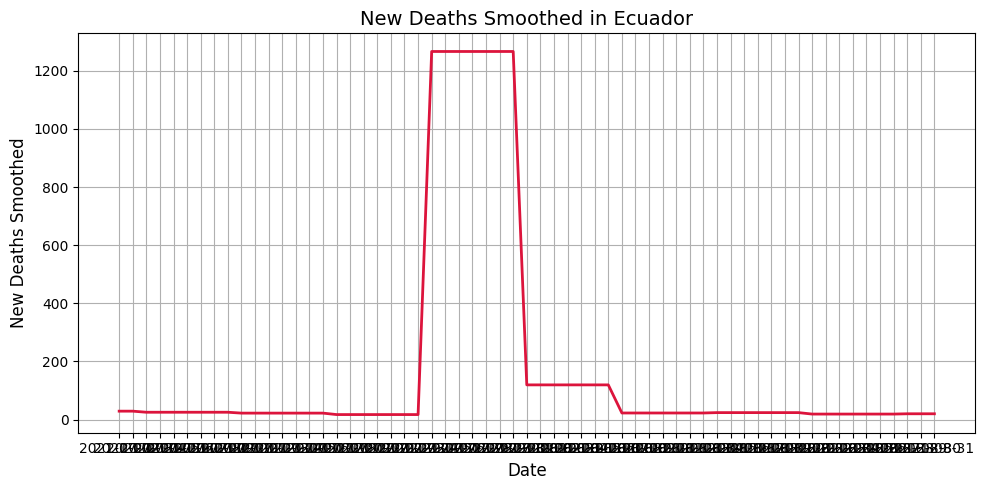

In [36]:

dfft=df[df['country']== 'Ecuador'][['survey_date', 'new_deaths_smoothed']]
dfft=dfft[(dfft['survey_date']> '2021-07-01') & (dfft['survey_date']< '2021-09-01')]
plt.figure(figsize=(10, 5))
plt.plot(dfft['survey_date'], dfft['new_deaths_smoothed'], color='crimson', linewidth=2)

plt.title('New Deaths Smoothed in Ecuador', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('New Deaths Smoothed', fontsize=12)
plt.grid(True)
plt.tight_layout()

# Mostra il grafico
plt.show()

In [37]:
dfft.to_csv('try.csv') #1266.286
df.loc[(df['country'] == 'Ecuador') & (df['new_deaths_smoothed'] > 1200), 'new_deaths_smoothed'] = 68
#prima del picco 17.0
#dopo del picco 119.143
#media  68

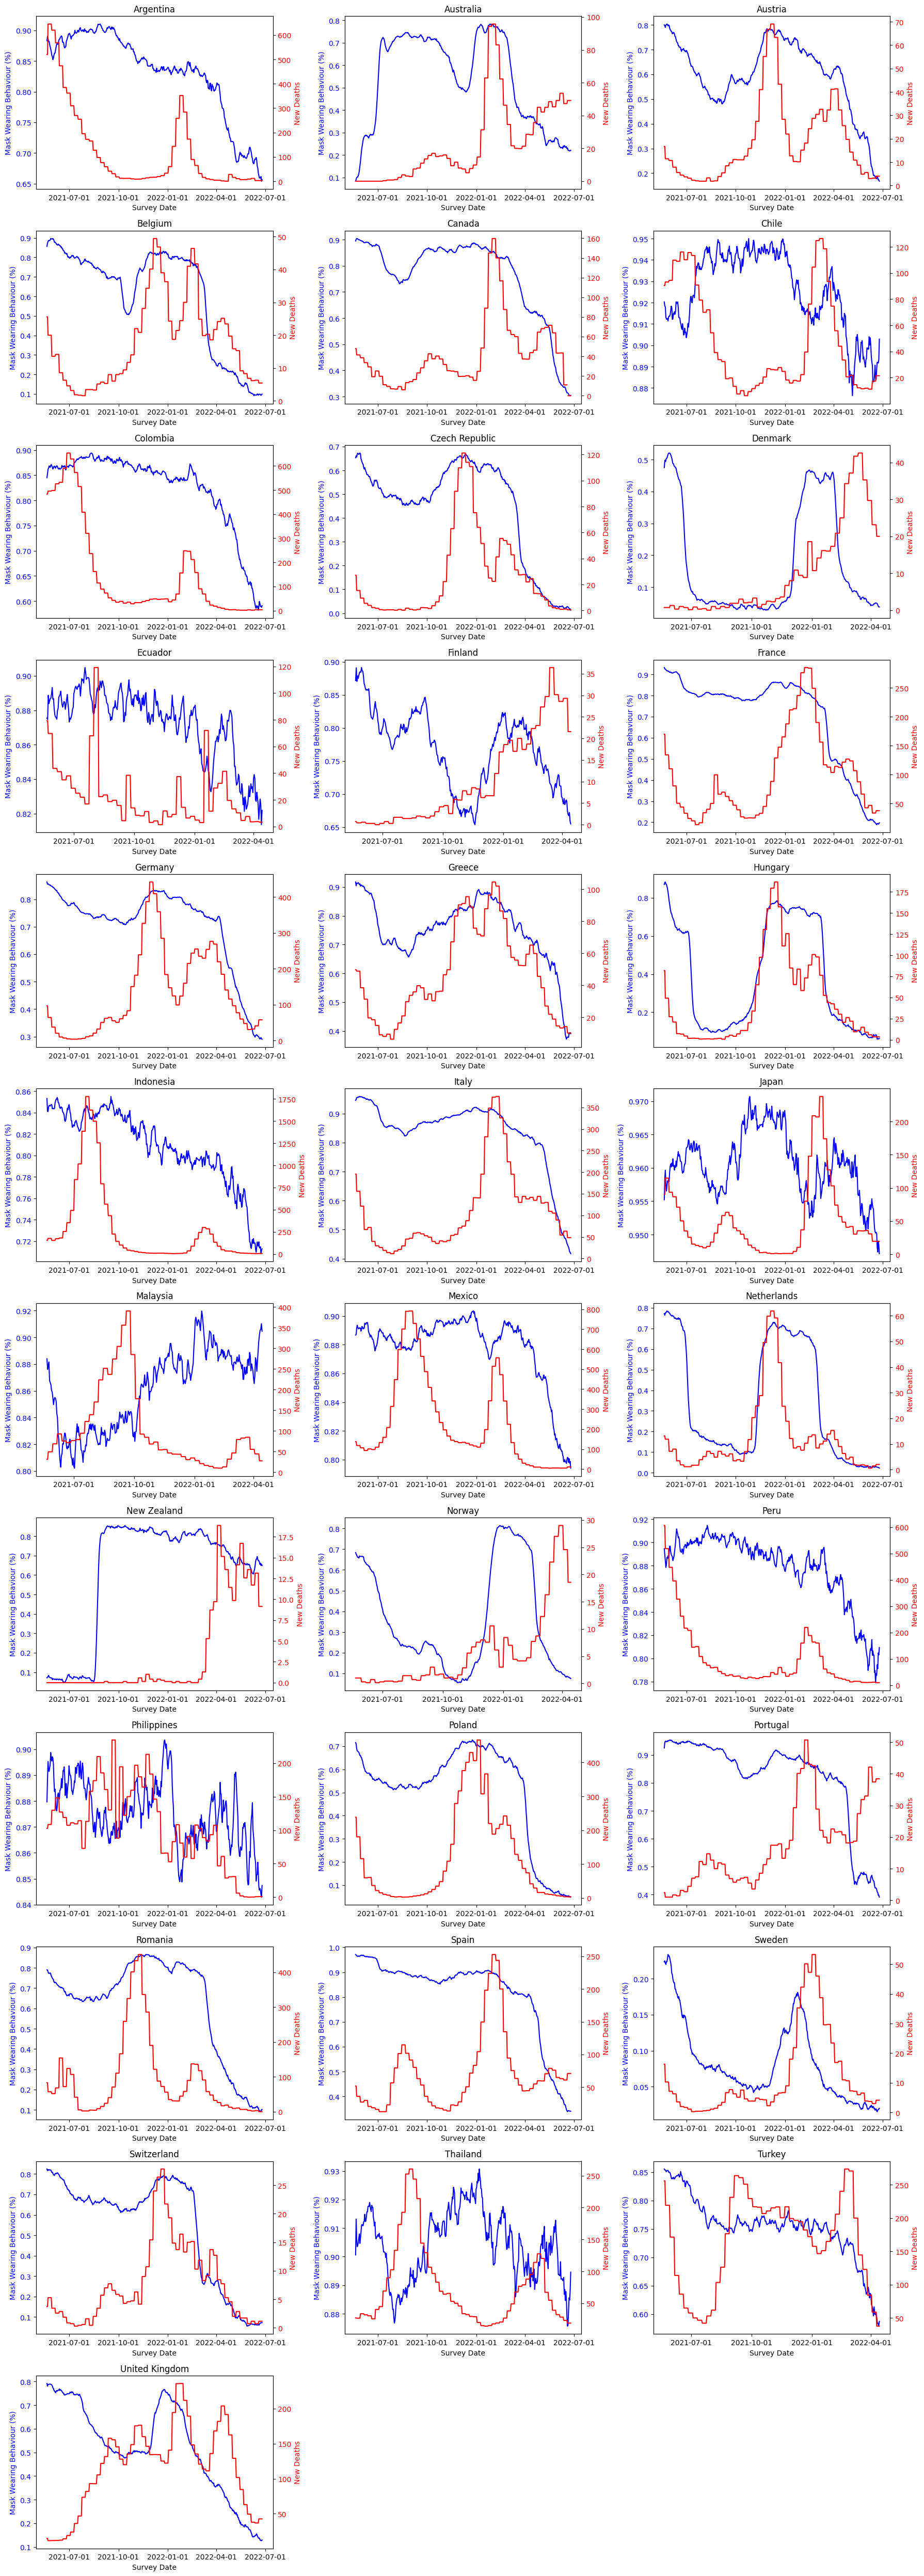

In [ ]:
behdeath = df[['country', 'pct_mask', 'survey_date', 'total_deaths', 'new_deaths_smoothed']].copy()
behdeath['survey_date'] = pd.to_datetime(behdeath['survey_date'])

lista_paesi = behdeath['country'].unique()  
fig, axs = plt.subplots(12, 3, figsize=(18, 50), sharex=False)
axs = axs.flatten() 

for i, paese in enumerate(lista_paesi):
    df_paese = behdeath[behdeath['country'] == paese].copy()
    df_paese.set_index('survey_date', inplace=True)     # imposta l'indice come datetime altriemnti non va
    # Calcolo media mobile 7 giorni solo su pct_mask
    pct_mask_smooth = df_paese['pct_mask'].rolling('7D', min_periods=1).mean()
    df_smooth = df_paese.copy()
    df_smooth['pct_mask'] = pct_mask_smooth
    # cambia indice per il plot
    df_smooth.reset_index(inplace=True)

    ax1 = axs[i]
    ax1.plot(df_smooth['survey_date'], df_smooth['pct_mask'], color='blue', label='Mask Wearing Behaviour (%)')
    ax1.set_ylabel('Mask Wearing Behaviour (%)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(df_smooth['survey_date'], df_smooth['new_deaths_smoothed'], color='red', label='New Deaths')
    ax2.set_ylabel('New Deaths', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    ax1.set_title(paese)
    ax1.set_xlabel('Survey Date')

    #date asse x non tutte ma solo alcune 
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=6))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
# Rimuove subplot vuoti
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


In [39]:
def boxplot1(correlations_df1, name1, title, nomesalvataggio):
    """Immagine con 1 boxplot"""
    # Pìpreparazione dati
    df1 = correlations_df1.copy()
    df1['dataset'] = name1
    combined_df = df1
    #figura
    plt.figure(figsize=(6, 6))
    ax = sns.boxplot(
        x='dataset',
        y='correlation',
        data=combined_df,
        width=0.3,
        showfliers=False,
        boxprops=dict(facecolor='white', edgecolor='black', linewidth=1), #per fare grandezza dei plot
        whiskerprops=dict(color='black', linewidth=1),
        capprops=dict(color='black', linewidth=1),
        medianprops=dict(color='red', linewidth=2)
    )

    # Aggiunta outlier
    add_outliers(ax, df1, 0)
    ax.set_xticklabels([name1], fontsize=14)

    # Formattazione
    plt.axhline(0, color='gray', linestyle=':', alpha=0.5)
    plt.ylim(-1, 1)
    plt.title(title, fontsize=14, pad=15)
    plt.ylabel('Correlations', fontsize=14)
    plt.xlabel('',fontsize=14)
    plt.grid(axis='y', linestyle=':', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'C:\\Users\\user\\Desktop\\immaginitt\\immparte2correlazione\\{nomesalvataggio}.png')
    plt.show()

## new cases vs beh

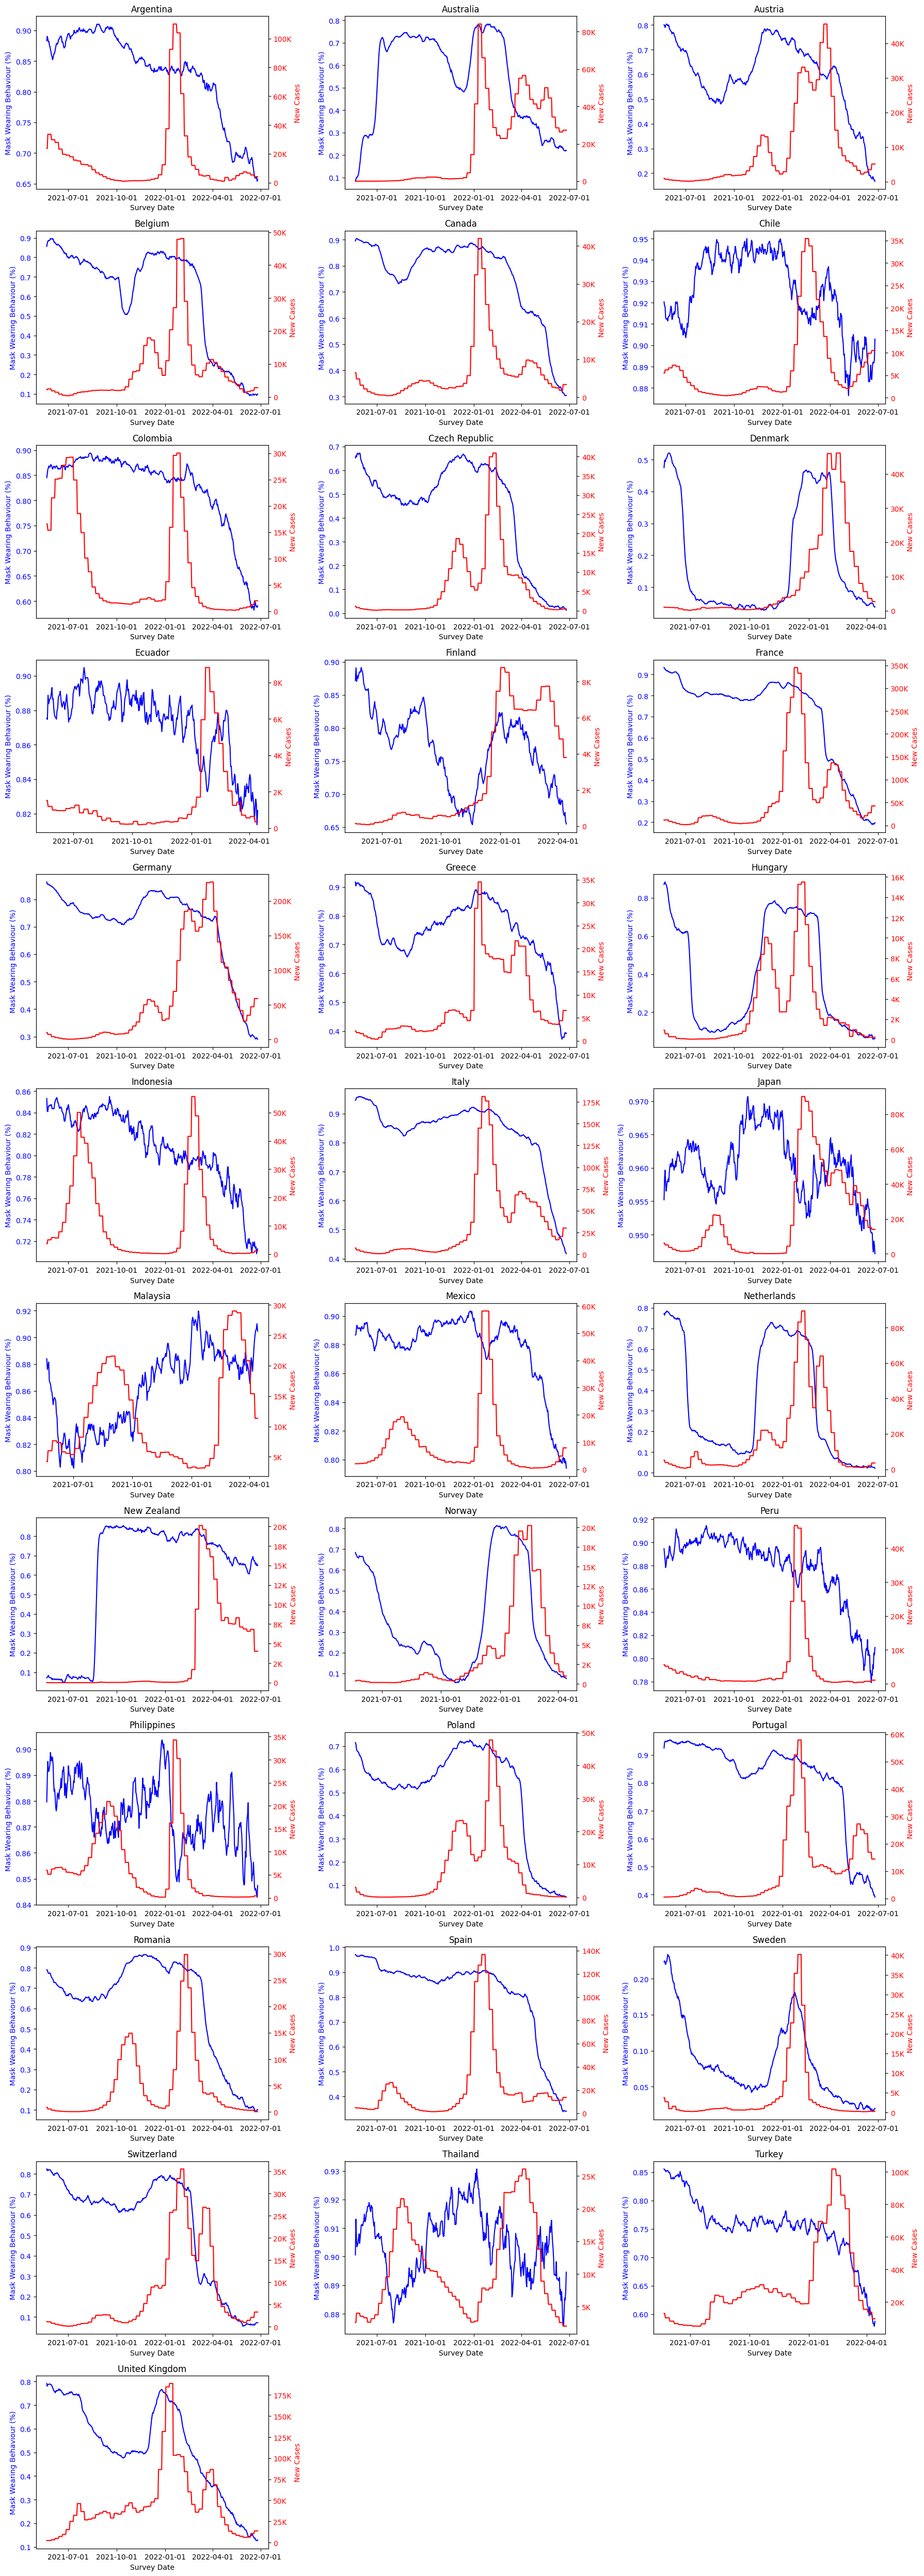

In [ ]:
import matplotlib.ticker as ticker
def millions_formatter(x, pos):
    if x >= 1e6:
        return f'{x*1e-6:.1f}M'  # oppure .0f se non vuoi decimali
    elif x >= 1e3:
        return f'{x*1e-3:.0f}K'
    else:
        return f'{int(x)}'



behcases = df[['country', 'pct_mask', 'survey_date', 'total_cases', 'new_cases_smoothed']].copy()
behcases['survey_date'] = pd.to_datetime(behcases['survey_date'])

lista_paesi =behcases['country'].unique()  
fig, axs = plt.subplots(12, 3, figsize=(18, 50), sharex=False)
axs = axs.flatten() 

for i, paese in enumerate(lista_paesi):
    df_paese = behcases[behcases['country'] == paese].copy()
    df_paese.set_index('survey_date', inplace=True)     # imposta l'indice come datetime altriemnti non va
    # media mobile settimanale 
    #df_smooth = df_paese[['pct_mask', 'new_cases_smoothed']].rolling('7D', min_periods=1).mean()
    # Calcolo media mobile 7 giorni solo su pct_mask
    pct_mask_smooth = df_paese['pct_mask'].rolling('7D', min_periods=1).mean()
    df_smooth = df_paese.copy()
    df_smooth['pct_mask'] = pct_mask_smooth
    # cambia indice per il plot
    df_smooth.reset_index(inplace=True)

    ax1 = axs[i]
    ax1.plot(df_smooth['survey_date'], df_smooth['pct_mask'], color='blue', label='Mask Wearing Behaviour (%)')
    ax1.set_ylabel('Mask Wearing Behaviour (%)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(df_smooth['survey_date'], df_smooth['new_cases_smoothed'], color='red', label='New Cases')
    ax2.set_ylabel('New Cases', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter)) #per mettere la M

    ax1.set_title(paese)
    ax1.set_xlabel('Survey Date')

    #date asse x non tutte ma solo alcune 
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=6))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    #ax1.tick_params(axis='x', labelrotation=90)

# Rimuove subplot vuoti
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

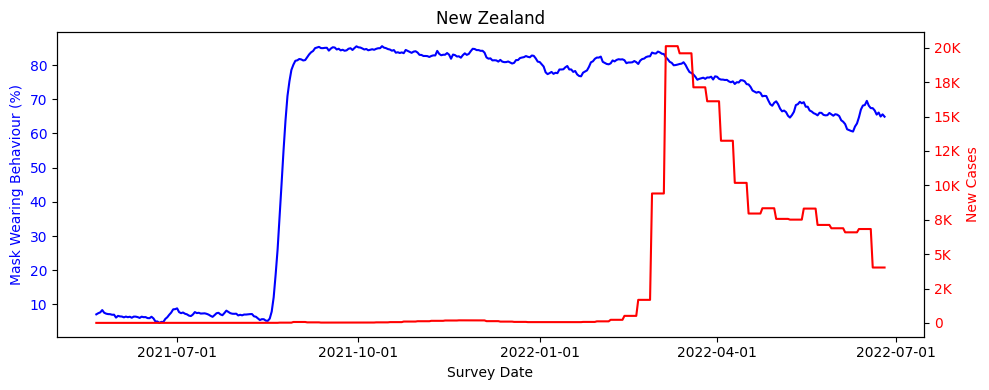

In [77]:
# funnzione per formattare l'asse y con K e M
def millions_formatter(x, pos):
    if x >= 1e6:
        return f'{x*1e-6:.1f}M'
    elif x >= 1e3:
        return f'{x*1e-3:.0f}K'
    else:
        return f'{int(x)}'

behcases = df[['country', 'pct_mask', 'survey_date', 'total_cases', 'new_cases_smoothed']].copy()
behcases['survey_date'] = pd.to_datetime(behcases['survey_date'])
behcases = behcases[behcases['country'] == 'New Zealand']

behcases.set_index('survey_date', inplace=True)
pct_mask_smooth = behcases['pct_mask'].rolling('7D', min_periods=1).mean()
behcases['pct_mask_smooth'] = pct_mask_smooth
behcases.reset_index(inplace=True)


fig, ax1 = plt.subplots(figsize=(10, 4))

ax1.plot(behcases['survey_date'], behcases['pct_mask_smooth']*100, color='blue', label='Mask Wearing Behaviour (%)')
ax1.set_ylabel('Mask Wearing Behaviour (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Survey Date')
ax1.set_title('New Zealand')

ax2 = ax1.twinx()
ax2.plot(behcases['survey_date'], behcases['new_cases_smoothed'], color='red', label='New Cases')
ax2.set_ylabel('New Cases', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))

ax1.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=6))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))


plt.tight_layout()
plt.savefig(r'C:\Users\user\Desktop\immaginitt\immparte2correlazione\BCASESzelanda.png', dpi=300, bbox_inches='tight')
plt.show()


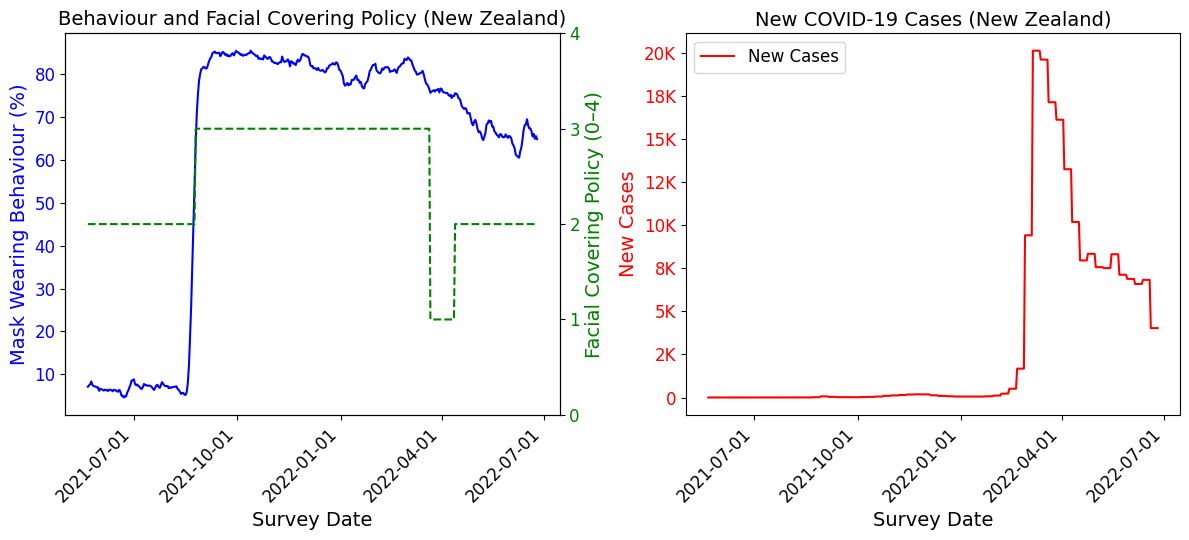

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator

# funzione per avere sull'asse y i K e M
def millions_formatter(x, pos):
    if x >= 1e6:
        return f'{x*1e-6:.1f}M'
    elif x >= 1e3:
        return f'{x*1e-3:.0f}K'
    else:
        return f'{int(x)}'

# bhecases
behcases = df[['country', 'pct_mask', 'survey_date', 'total_cases', 'new_cases_smoothed']].copy()
behcases['survey_date'] = pd.to_datetime(behcases['survey_date'])
behcases = behcases[behcases['country'] == 'New Zealand']
behcases.set_index('survey_date', inplace=True)
behcases['pct_mask_smooth'] = behcases['pct_mask'].rolling('7D', min_periods=1).mean()
behcases.reset_index(inplace=True)

# face covering
ds = pd.read_csv('face-covering-policies-covid.csv')
ds_nz = ds[ds['Entity'] == 'New Zealand'].copy()
ds_nz['Day'] = pd.to_datetime(ds_nz['Day'])
ds_nz.rename(columns={'Day': 'survey_date', 'Facial Coverings': 'facial_covering'}, inplace=True)

behcases = pd.merge_asof(
    behcases.sort_values('survey_date'),
    ds_nz[['survey_date', 'facial_covering']].sort_values('survey_date'),
    on='survey_date',
    direction='backward'
)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5.5), sharex=True)  # ideale per A4 orizzontale

# --- GRAFICO A SINISTRA: mask wearing + facial covering ---
color_mask = 'blue'
color_policy = 'green'

ax1.plot(behcases['survey_date'], behcases['pct_mask_smooth']*100, color=color_mask, label='Mask Wearing Behaviour (%)')
ax1.set_ylabel('Mask Wearing Behaviour (%)', color=color_mask, fontsize=14)
ax1.set_xlabel('Survey Date', fontsize=14)
ax1.set_title('Behaviour and Facial Covering Policy (New Zealand)', fontsize=14)
ax1.tick_params(axis='y', labelcolor=color_mask, labelsize=12)
ax1.tick_params(axis='x', labelsize=12)

# Asse secondario per facial covering
ax1b = ax1.twinx()
ax1b.plot(behcases['survey_date'], behcases['facial_covering'], color=color_policy, linestyle='--', label='Facial Covering Policy (0–4)')
ax1b.set_ylabel('Facial Covering Policy (0–4)', color=color_policy, fontsize=14)
ax1b.tick_params(axis='y', labelcolor=color_policy, labelsize=12)
ax1b.set_ylim(0, 4)
ax1b.yaxis.set_major_locator(MultipleLocator(1))

# --- GRAFICO A DESTRA: new cases smoothed ---
color_cases = 'red'
ax2.plot(behcases['survey_date'], behcases['new_cases_smoothed'], color=color_cases, label='New Cases')
ax2.set_ylabel('New Cases', color=color_cases, fontsize=14)
ax2.set_xlabel('Survey Date', fontsize=14)
ax2.set_title('New COVID-19 Cases (New Zealand)', fontsize=14)
ax2.tick_params(axis='y', labelcolor=color_cases, labelsize=12)
ax2.tick_params(axis='x', labelsize=12)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
ax2.legend(loc='upper left', fontsize=12)


for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(r'C:\Users\user\Desktop\immaginitt\immparte2correlazione\NZ_dualplots.png', dpi=600, bbox_inches='tight')
plt.show()


analisi multivariata

In [42]:
b = df[['pct_mask', 'new_deaths_smoothed', 'new_cases_smoothed']].copy().dropna() 
print(b[['new_deaths_smoothed', 'new_cases_smoothed']].corr()     )            #serve per vedere se sono indipendenti le due 

X_vif = add_constant(b[['new_deaths_smoothed', 'new_cases_smoothed']])
vif_data = pd.DataFrame()
vif_data['Variable'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print("\nVariance Inflation Factor (VIF): ")
print(vif_data)

X = b[['new_deaths_smoothed', 'new_cases_smoothed']]
y = b['pct_mask']

model = LinearRegression().fit(X, y)

print(" \n Coefficienti -beta:", model.coef_)
print("Intercetta -alpha:", model.intercept_)
print("R^2:", model.score(X, y))

                     new_deaths_smoothed  new_cases_smoothed
new_deaths_smoothed              1.00000             0.31551
new_cases_smoothed               0.31551             1.00000

Variance Inflation Factor (VIF): 
              Variable       VIF
0                const  1.425852
1  new_deaths_smoothed  1.110552
2   new_cases_smoothed  1.110552
 
 Coefficienti -beta: [4.99625789e-04 5.82658532e-08]
Intercetta -alpha: 0.6340675566097753
R^2: 0.05707908926570482


granger causality

In [43]:
grangers_causation_matrix(df[['pct_mask', 'new_cases_smoothed']].dropna(), variables =['pct_mask', 'new_cases_smoothed']) 
#in quetso caso ho che <0.05 ottengo che x do not granger cause y.  invece altro ho che new deaths è granger cause di y

pct_mask_x  new_cases_smoothed_x
pct_mask_y                1.0000                0.0243
new_cases_smoothed_y      0.0051                1.0000

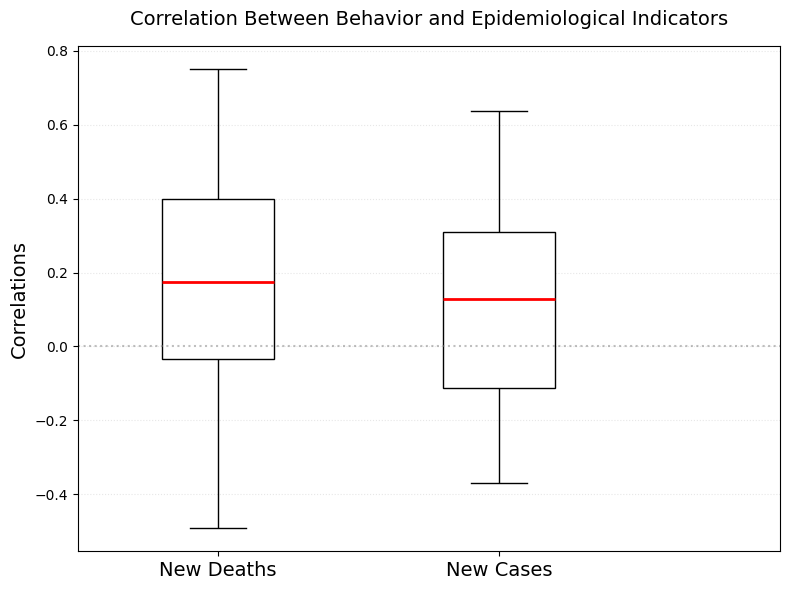

In [44]:
corr1=calculate_correlations("pct_mask","new_deaths_smoothed")
corr2=calculate_correlations("pct_mask", "new_cases_smoothed")
boxplot2(corr1,corr2, 'New Deaths', 'New Cases', 'Correlation Between Behavior and Epidemiological Indicators', 'NCND')

## beh vs CHI

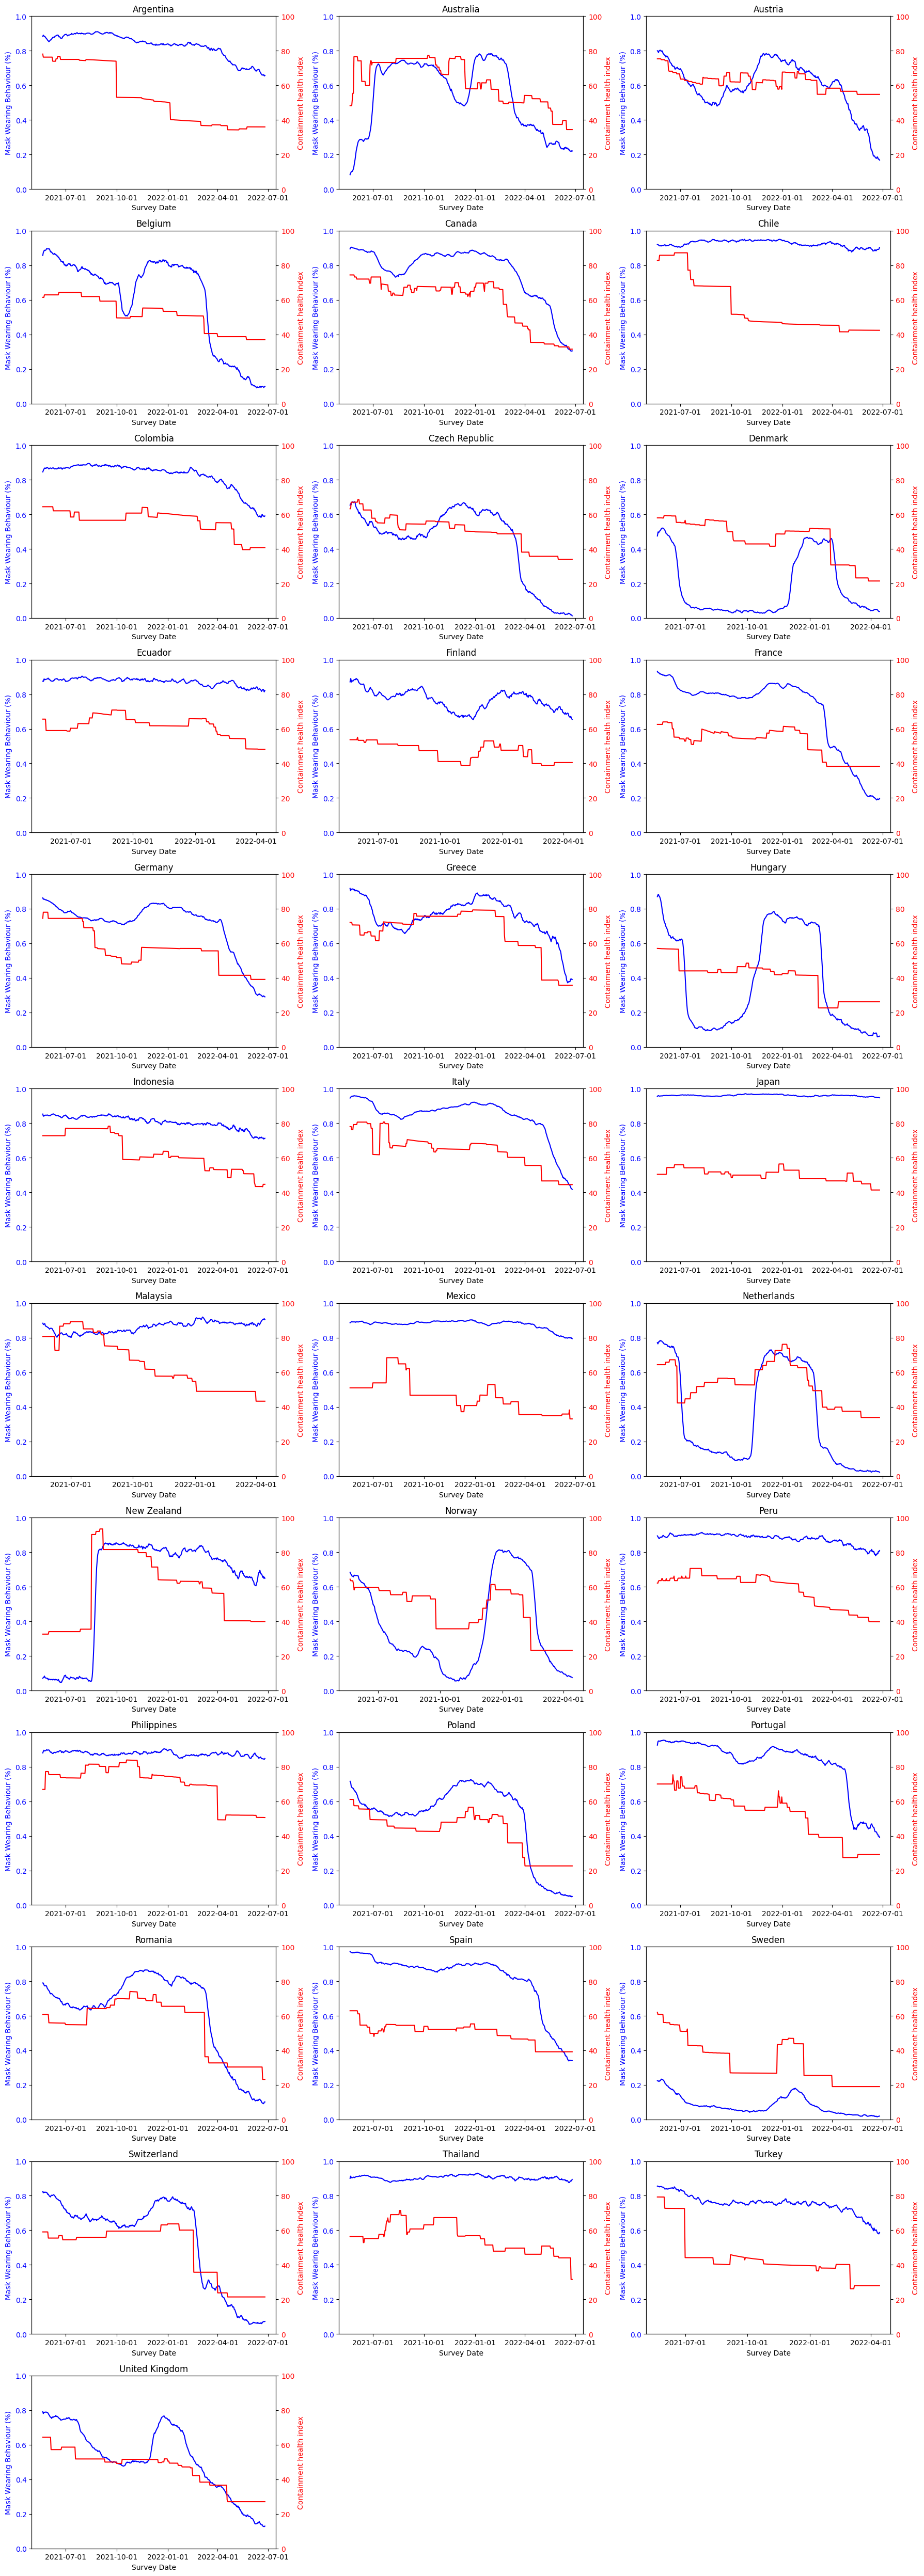

In [ ]:
behchi = df[['country', 'pct_mask', 'survey_date', 'Containment health index']].copy()
behchi['survey_date'] = pd.to_datetime(behchi['survey_date'])


lista_paesi =behchi['country'].unique()  
fig, axs = plt.subplots(12, 3, figsize=(18, 50), sharex=False)
axs = axs.flatten() 

for i, paese in enumerate(lista_paesi):
    df_paese = behchi[behchi['country'] == paese].copy()
    df_paese.set_index('survey_date', inplace=True)     # imposta l'indice come datetime altriemnti non va
    # media mobile settimanale 
    df_smooth = df_paese[['pct_mask']].rolling('7D', min_periods=1).mean()

    # cambia indice per il plot
    df_smooth.reset_index(inplace=True)
   

    ax1 = axs[i]
    ax1.plot(df_smooth['survey_date'], df_smooth['pct_mask'], color='blue', label='Mask Wearing Behaviour (%)')
    ax1.set_ylabel('Mask Wearing Behaviour (%)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_ylim(0, 1)     


    ax2 = ax1.twinx()
    ax2.plot(df_smooth['survey_date'], df_paese['Containment health index'], color='red', label='Total Cases')
    ax2.set_ylabel('Containment health index', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter)) #per mettere la M
    ax2.set_ylim(0, 100)

    ax1.set_title(paese)
    ax1.set_xlabel('Survey Date')

    #date asse x non tutte ma solo alcune 
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=6))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rimuove subplot vuoti
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

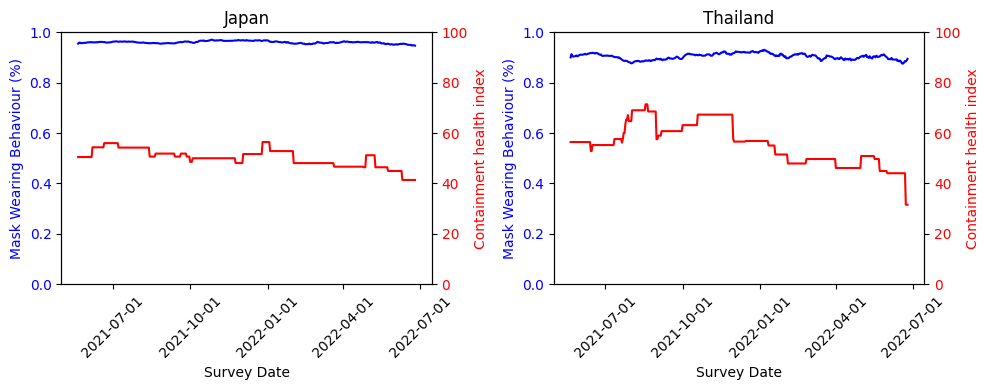

In [46]:
behchi = df[['country', 'pct_mask', 'survey_date', 'Containment health index']].copy()
behchi['survey_date'] = pd.to_datetime(behchi['survey_date'])
behchi = behchi[behchi['country'].isin(['Japan', 'Thailand'])]


lista_paesi = ['Japan', 'Thailand']
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=False)
axs = axs.flatten() 

for i, paese in enumerate(lista_paesi):
    df_paese = behchi[behchi['country'] == paese].copy()
    df_paese.set_index('survey_date', inplace=True)     # imposta l'indice come datetime altriemnti non va
    # media mobile settimanale 
    df_smooth = df_paese[['pct_mask']].rolling('7D', min_periods=1).mean()

    # cambia indice per il plot
    df_smooth.reset_index(inplace=True)
   

    ax1 = axs[i]
    ax1.plot(df_smooth['survey_date'], df_smooth['pct_mask'], color='blue', label='Mask Wearing Behaviour (%)')
    ax1.set_ylabel('Mask Wearing Behaviour (%)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_ylim(0, 1)     


    ax2 = ax1.twinx()
    ax2.plot(df_smooth['survey_date'], df_paese['Containment health index'], color='red', label='Total Cases')
    ax2.set_ylabel('Containment health index', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter)) #per mettere la M
    ax2.set_ylim(0, 100)

    ax1.set_title(paese)
    ax1.set_xlabel('Survey Date')

    #date asse x non tutte ma solo alcune 
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=6))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.tick_params(axis='x', labelrotation=45)

# Rimuove subplot vuoti
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.savefig(r'C:\Users\user\Desktop\immaginitt\immparte2correlazione\BCHIjapanthailand.png', dpi=300, bbox_inches='tight')
plt.show()

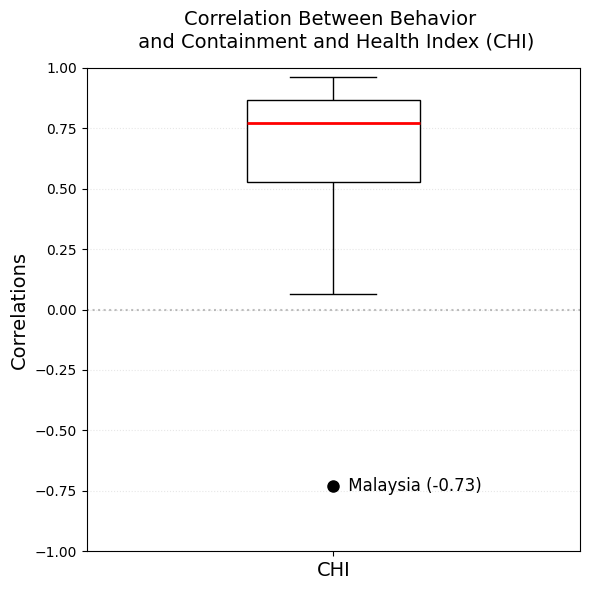

In [ ]:
cor = calculate_correlations("pct_mask", "Containment health index")
df1 = cor.copy()
df1['dataset'] = 'CHI'
combined_df = df1

plt.figure(figsize=(6, 6))
ax = sns.boxplot(
    x='dataset',
    y='correlation',
    data=combined_df,
    width=0.35, 
    showfliers=False,
    boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
    whiskerprops=dict(color='black', linewidth=1),
    capprops=dict(color='black', linewidth=1),
    medianprops=dict(color='red', linewidth=2)
)

add_outliers(ax, df1, x_pos=0)
ax.set_xticklabels(['CHI'], fontsize=14)

plt.axhline(0, color='gray', linestyle=':', alpha=0.5)
plt.ylim(-1, 1)
plt.title('Correlation Between Behavior \n and Containment and Health Index (CHI)', fontsize=14, pad=15)
plt.ylabel('Correlations', fontsize=14)
plt.xlabel('', fontsize=14)
plt.grid(axis='y', linestyle=':', alpha=0.3)
plt.xlim(-0.5, 0.5)

plt.tight_layout()
plt.savefig('C:\\Users\\user\\Desktop\\immaginitt\\immparte2correlazione\\Behchiboxplot.png')
plt.show()


In [48]:
print(shannon('Malaysia', 'pct_mask'))
print(shannon('Malaysia', 'Containment health index'))

0.9018536441248436
0.9551388153059258


In [ ]:
##prova di analisi multivariata per capire effetto di casi e morti sull'uso della mascherina 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

b = df[['country','pct_mask', 'Containment health index']].copy().dropna()
b = b[b['country'] == 'Malaysia']

X = b[['Containment health index']]
y = b['pct_mask']

X = sm.add_constant(X)  # aggiunge la colonna 'const'

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               pct_mask   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     374.9
Date:                Sat, 02 Aug 2025   Prob (F-statistic):           3.94e-56
Time:                        11:15:04   Log-Likelihood:                 748.76
No. Observations:                 328   AIC:                            -1494.
Df Residuals:                     326   BIC:                            -1486.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [50]:

b = df[['country','pct_mask', 'Containment health index']].copy().dropna() 


X = b[['Containment health index']]
y = b['pct_mask']

model = LinearRegression().fit(X, y)

print("Coefficienti -beta:", model.coef_)
print("Intercetta -alpha:", model.intercept_)
print("R^2:", model.score(X, y))

Coefficienti -beta: [0.01131821]
Intercetta -alpha: 0.06572852912349814
R^2: 0.3378935472182779


In [51]:
grangers_causation_matrix(df[['pct_mask', 'Containment health index']].dropna(), variables =['pct_mask', 'Containment health index']) 

pct_mask_x  Containment health index_x
pct_mask_y                      1.0000                         0.0
Containment health index_y      0.1216                         1.0

## CHI  vs BEL; AWA; TRU

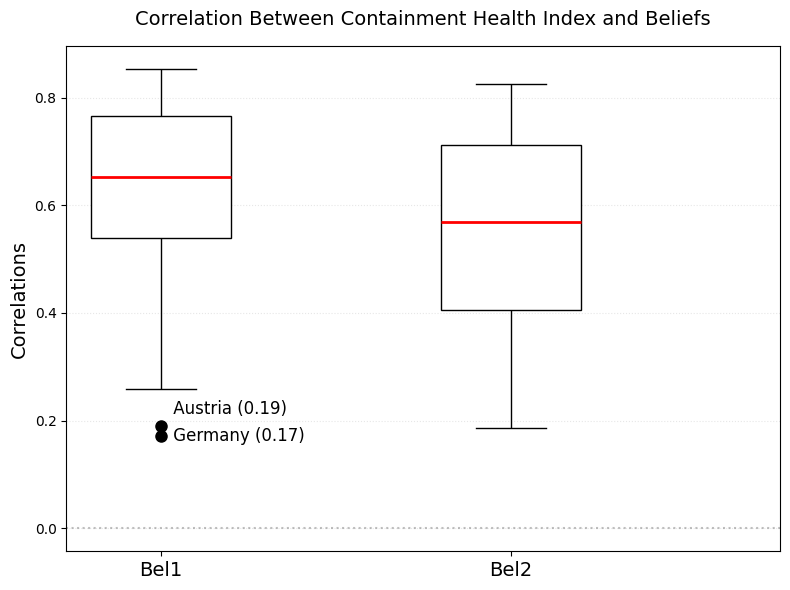

In [52]:
corr1=calculate_correlations("Containment health index","pct_worried_catch_covid")
corr2=calculate_correlations("Containment health index", "pct_belief_masking_effective")
boxplot2(corr1,corr2, 'Bel1', 'Bel2', 'Correlation Between Containment Health Index and Beliefs', 'CHIBel')

In [53]:
print(shannon('Austria', 'Containment health index'))
print(shannon('Germany', 'Containment health index'))
print(shannon('Austria', 'pct_worried_catch_covid'))
print(shannon('Germany', 'pct_worried_catch_covid'))

0.8319222750593229
0.6965053988437852
0.8753135930641495
0.9181089517036987


In [54]:
b = df[['country','pct_worried_catch_covid', 'Containment health index', 'pct_belief_masking_effective']].copy().dropna()
# Prima regressione: CHI → pct_worried_catch_covid
y1 = b['pct_worried_catch_covid']
X = sm.add_constant(b['Containment health index'])
model1 = sm.OLS(y1, X).fit()
print(model1.summary())

                               OLS Regression Results                              
Dep. Variable:     pct_worried_catch_covid   R-squared:                       0.132
Model:                                 OLS   Adj. R-squared:                  0.132
Method:                      Least Squares   F-statistic:                     2003.
Date:                     Sat, 02 Aug 2025   Prob (F-statistic):               0.00
Time:                             11:15:05   Log-Likelihood:                 2607.0
No. Observations:                    13165   AIC:                            -5210.
Df Residuals:                        13163   BIC:                            -5195.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

In [55]:
# Seconda regressione: CHI → pct_belief_masking_effective
y2 = b['pct_belief_masking_effective']
model2 = sm.OLS(y2, X).fit()
print(model2.summary())

                                 OLS Regression Results                                 
Dep. Variable:     pct_belief_masking_effective   R-squared:                       0.228
Model:                                      OLS   Adj. R-squared:                  0.228
Method:                           Least Squares   F-statistic:                     3893.
Date:                          Sat, 02 Aug 2025   Prob (F-statistic):               0.00
Time:                                  11:15:05   Log-Likelihood:                 10787.
No. Observations:                         13165   AIC:                        -2.157e+04
Df Residuals:                             13163   BIC:                        -2.155e+04
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------

In [56]:
y1 = b['Containment health index']

X = sm.add_constant(b['pct_belief_masking_effective'])
model1 = sm.OLS(y1, X).fit()
print(model1.summary())

                               OLS Regression Results                               
Dep. Variable:     Containment health index   R-squared:                       0.228
Model:                                  OLS   Adj. R-squared:                  0.228
Method:                       Least Squares   F-statistic:                     3893.
Date:                      Sat, 02 Aug 2025   Prob (F-statistic):               0.00
Time:                              11:15:05   Log-Likelihood:                -51812.
No. Observations:                     13165   AIC:                         1.036e+05
Df Residuals:                         13163   BIC:                         1.036e+05
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

In [57]:
grangers_causation_matrix(
    df[['Containment health index', 'pct_worried_catch_covid']].dropna(), 
    variables=['Containment health index', 'pct_worried_catch_covid']
)

Containment health index_x  \
Containment health index_y                         1.0   
pct_worried_catch_covid_y                          0.0   

                            pct_worried_catch_covid_x  
Containment health index_y                     0.1292  
pct_worried_catch_covid_y                      1.0000

In [58]:
grangers_causation_matrix(
    df[['Containment health index', 'pct_belief_masking_effective']].dropna(), 
    variables=['Containment health index', 'pct_belief_masking_effective']
)

Containment health index_x  \
Containment health index_y                             1.0   
pct_belief_masking_effective_y                         0.0   

                                pct_belief_masking_effective_x  
Containment health index_y                              0.0002  
pct_belief_masking_effective_y                          1.0000

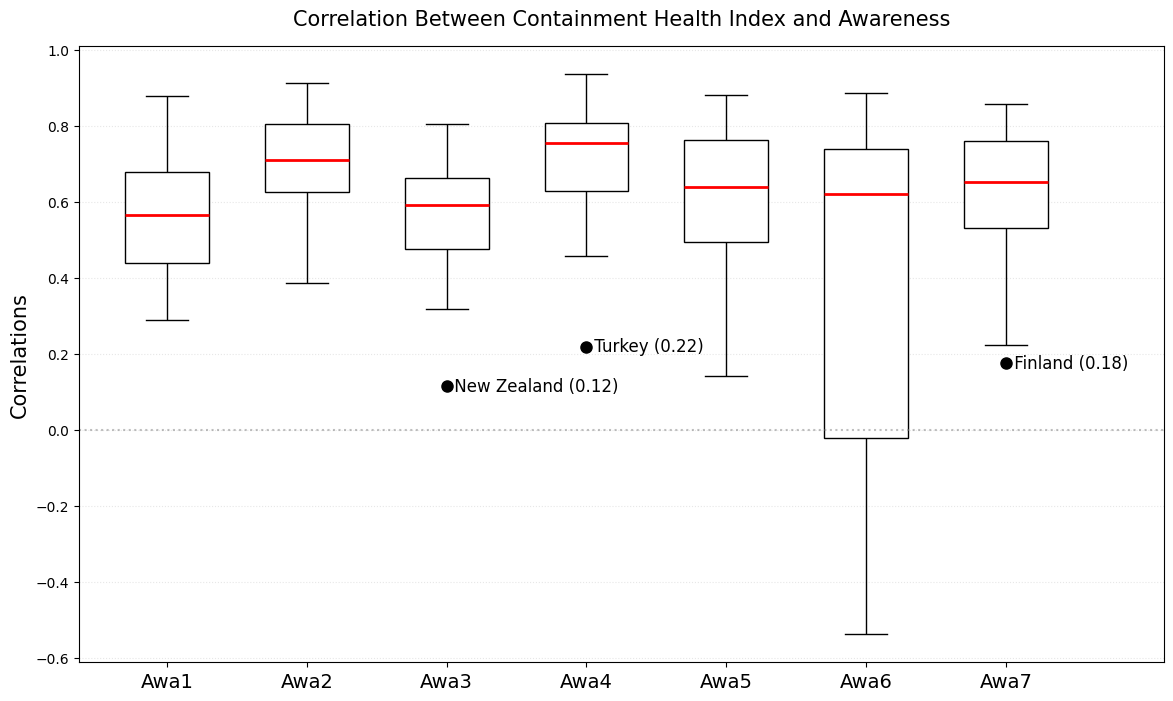

In [59]:
corr1=calculate_correlations("Containment health index","pct_received_news_local_health")
corr2=calculate_correlations("Containment health index","pct_received_news_experts")
corr3=calculate_correlations("Containment health index","pct_received_news_who")
corr4=calculate_correlations("Containment health index","pct_received_news_govt_health")
corr5=calculate_correlations("Containment health index","pct_received_news_politicians")
corr6=calculate_correlations("Containment health index","pct_received_news_journalists")
corr7=calculate_correlations("Containment health index","pct_received_news_friends")
corr=[corr1, corr2, corr3, corr4, corr5, corr6, corr7]
names=['Awa1', 'Awa2','Awa3','Awa4','Awa5','Awa6','Awa7']
boxplot7(corr, names, 'Correlation Between Containment Health Index and Awareness', 'CHIAwa')

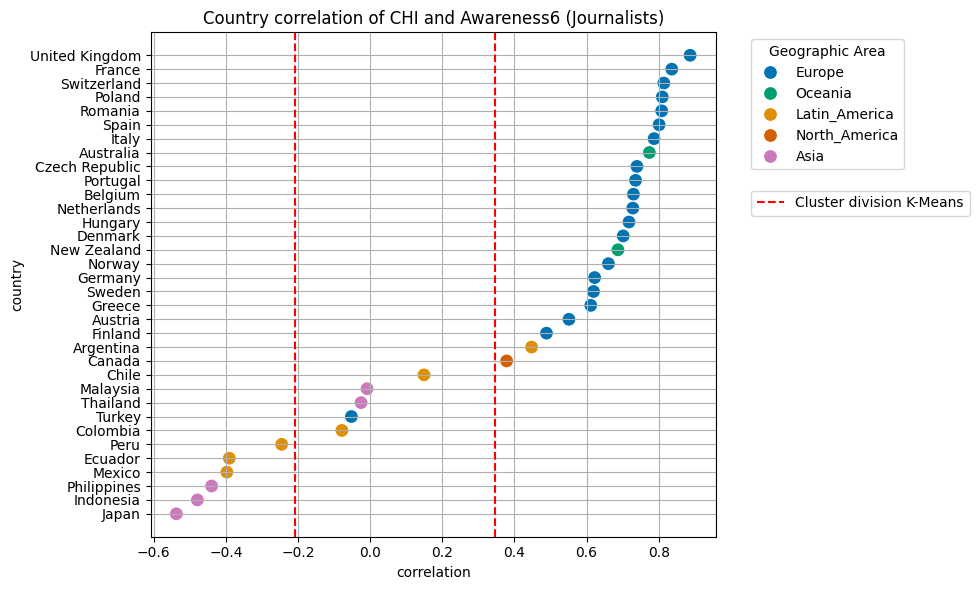

In [60]:
plot_aree(corr6, 'Country correlation of CHI and Awareness6 (Journalists)', 'CHI-awa-analisi6')

In [61]:
b = df[['country', 'Containment health index', 
        'pct_received_news_local_health', 'pct_received_news_experts', 
        'pct_received_news_who', 'pct_received_news_govt_health', 
        'pct_received_news_politicians', 'pct_received_news_journalists', 
        'pct_received_news_friends']].copy().dropna()

# Prima regressione: CHI → awareness variables
y1 = b['Containment health index']
X = sm.add_constant(b[['pct_received_news_local_health', 
                       'pct_received_news_experts', 
                       'pct_received_news_who', 
                       'pct_received_news_govt_health', 
                       'pct_received_news_politicians', 
                       'pct_received_news_journalists', 
                       'pct_received_news_friends']])
model1 = sm.OLS(y1, X).fit()
print(model1.summary())





                               OLS Regression Results                               
Dep. Variable:     Containment health index   R-squared:                       0.456
Model:                                  OLS   Adj. R-squared:                  0.455
Method:                       Least Squares   F-statistic:                     1570.
Date:                      Sat, 02 Aug 2025   Prob (F-statistic):               0.00
Time:                              11:15:09   Log-Likelihood:                -49391.
No. Observations:                     13134   AIC:                         9.880e+04
Df Residuals:                         13126   BIC:                         9.886e+04
Df Model:                                 7                                         
Covariance Type:                  nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

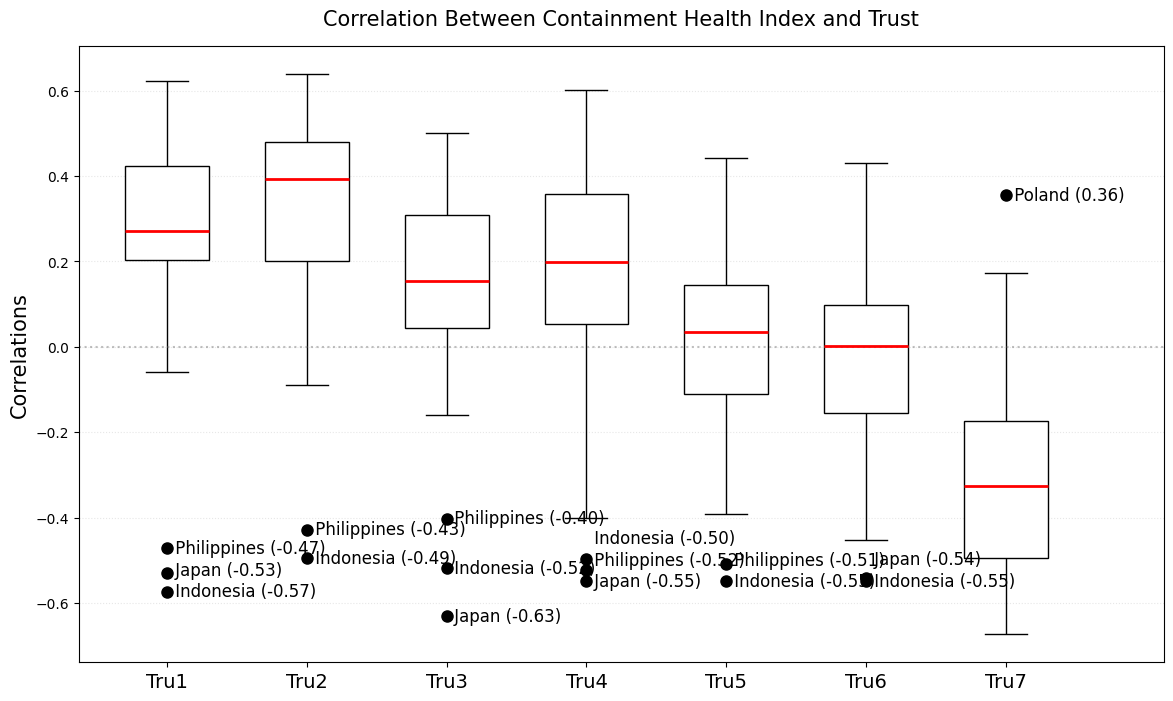

In [62]:
cort1=calculate_correlations("Containment health index","pct_trust_covid_info_local_health")
cort2=calculate_correlations("Containment health index","pct_trust_covid_info_experts")
cort3=calculate_correlations("Containment health index","pct_trust_covid_info_who")
cort4=calculate_correlations("Containment health index","pct_trust_covid_info_govt_health")
cort5=calculate_correlations("Containment health index","pct_trust_covid_info_politicians")
cort6=calculate_correlations("Containment health index","pct_trust_covid_info_journalists")
cort7=calculate_correlations("Containment health index","pct_trust_covid_info_friends")
cort=[cort1, cort2, cort3, cort4, cort5, cort6, cort7]
names=['Tru1', 'Tru2','Tru3','Tru4','Tru5','Tru6','Tru7']
boxplot7(cort, names, 'Correlation Between Containment Health Index and Trust', 'CHITru')

## new cases vs bel

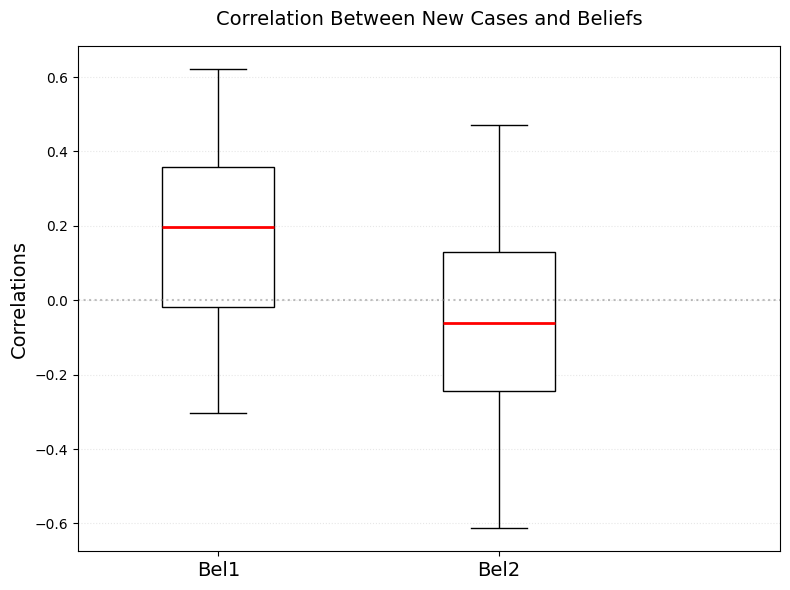

In [63]:
corr1=calculate_correlations("new_cases_smoothed","pct_worried_catch_covid")
corr2=calculate_correlations("new_cases_smoothed", "pct_belief_masking_effective")
boxplot2(corr1,corr2, 'Bel1', 'Bel2', 'Correlation Between New Cases and Beliefs', 'CasiBel')

In [64]:
grangers_causation_matrix(
    df[['new_cases_smoothed', 'pct_worried_catch_covid']].dropna(), 
    variables=['new_cases_smoothed', 'pct_worried_catch_covid']
)

new_cases_smoothed_x  pct_worried_catch_covid_x
new_cases_smoothed_y                     1.0000                     0.0345
pct_worried_catch_covid_y                0.1061                     1.0000

In [65]:
grangers_causation_matrix(
    df[['new_cases_smoothed', 'pct_belief_masking_effective']].dropna(), 
    variables=['new_cases_smoothed', 'pct_belief_masking_effective']
)

new_cases_smoothed_x  \
new_cases_smoothed_y                          1.0000   
pct_belief_masking_effective_y                0.6146   

                                pct_belief_masking_effective_x  
new_cases_smoothed_y                                    0.0537  
pct_belief_masking_effective_y                          1.0000

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

b = df[['country','new_cases_smoothed', 'pct_belief_masking_effective','pct_worried_catch_covid' ]].copy().dropna()

X = b[['pct_belief_masking_effective','pct_worried_catch_covid']]
y = b['new_cases_smoothed']

X = sm.add_constant(X)  # aggiunge la colonna 'const'

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     new_cases_smoothed   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.885
Date:                Sat, 02 Aug 2025   Prob (F-statistic):             0.0206
Time:                        11:15:13   Log-Likelihood:            -1.5396e+05
No. Observations:               13165   AIC:                         3.079e+05
Df Residuals:                   13162   BIC:                         3.079e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

## cases death VS chi

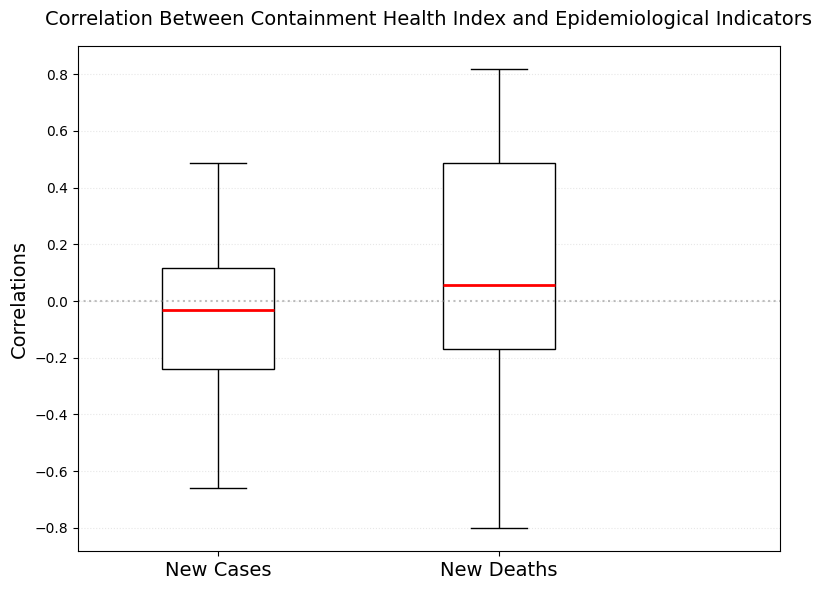

In [67]:
corr1=calculate_correlations("Containment health index", "new_cases_smoothed")
corr2=calculate_correlations( "Containment health index", "new_deaths_smoothed")
boxplot2(corr1,corr2, 'New Cases', 'New Deaths', 'Correlation Between Containment Health Index and Epidemiological Indicators', 'CHIcasideaths')

In [68]:
grangers_causation_matrix(
    df[['Containment health index', 'new_cases_smoothed']].dropna(), 
    variables=['Containment health index', 'new_cases_smoothed']
)

Containment health index_x  new_cases_smoothed_x
Containment health index_y                      1.0000                0.0165
new_cases_smoothed_y                            0.0046                1.0000

In [69]:
grangers_causation_matrix(
    df[['Containment health index', 'new_deaths_smoothed']].dropna(), 
    variables=['Containment health index', 'new_deaths_smoothed']
)

Containment health index_x  new_deaths_smoothed_x
Containment health index_y                         1.0                 0.0448
new_deaths_smoothed_y                              0.0                 1.0000

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

b = df[['country','Containment health index','new_cases_smoothed', 'new_deaths_smoothed' ]].copy().dropna()

X = b[['new_cases_smoothed', 'new_deaths_smoothed']]
y = b['Containment health index']

X = sm.add_constant(X)  # aggiunge la colonna 'const'

model = sm.OLS(y, X).fit()

# stampa il riepilogo con β, p-value, R², ecc.
print(model.summary())

                               OLS Regression Results                               
Dep. Variable:     Containment health index   R-squared:                       0.047
Model:                                  OLS   Adj. R-squared:                  0.047
Method:                       Least Squares   F-statistic:                     328.5
Date:                      Sat, 02 Aug 2025   Prob (F-statistic):          5.85e-140
Time:                              11:15:16   Log-Likelihood:                -53290.
No. Observations:                     13187   AIC:                         1.066e+05
Df Residuals:                         13184   BIC:                         1.066e+05
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [ ]:
X = b[['Containment health index']]
y = b['new_cases_smoothed']  

X = sm.add_constant(X)  # aggiunge la colonna 'const'

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     new_cases_smoothed   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     12.44
Date:                Sat, 02 Aug 2025   Prob (F-statistic):           0.000421
Time:                        11:15:16   Log-Likelihood:            -1.5420e+05
No. Observations:               13187   AIC:                         3.084e+05
Df Residuals:                   13185   BIC:                         3.084e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [ ]:
X = b[['Containment health index']]
y = b['new_deaths_smoothed']   

X = sm.add_constant(X)  # aggiunge la colonna 'const'

model = sm.OLS(y, X).fit()

print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     new_deaths_smoothed   R-squared:                       0.038
Model:                             OLS   Adj. R-squared:                  0.038
Method:                  Least Squares   F-statistic:                     521.2
Date:                 Sat, 02 Aug 2025   Prob (F-statistic):          3.65e-113
Time:                         11:15:16   Log-Likelihood:                -82666.
No. Observations:                13187   AIC:                         1.653e+05
Df Residuals:                    13185   BIC:                         1.654e+05
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const         